In [1]:
import numpy as np
from scipy.integrate import quad
from scipy.optimize import minimize
import math
#import scipy.stats as stats
from scipy import stats
import os
import joblib
from astropy.cosmology import FlatLambdaCDM, wCDM
import astropy.units as u
import astropy.coordinates 
from astropy import cosmology
from astropy.coordinates import Distance
from astropy import constants as const
import random
import getdist
import corner
from getdist import plots, MCSamples
import sys
from scipy.stats import gaussian_kde
from tqdm import tqdm
import matplotlib.ticker as ticker

import pandas as pd
from pandas import DataFrame
import emcee
import corner
from astropy.cosmology import wCDM
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, uniform
from IPython.display import display, Latex
from scipy.stats import gaussian_kde
import warnings
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy.stats import norm
from scipy.stats import skewnorm
from scipy.stats import skew
from chainconsumer import Chain, ChainConsumer, ChainConfig, PlotConfig,Truth 
import h5py

warnings.filterwarnings("ignore")

# If you want to match the text literally without using regex special characters:
warnings.filterwarnings("ignore", message=r"fine_bins not large enough to well sample smoothing scale")

# If you actually need to use special regex characters like .* for any character repetition:
warnings.filterwarnings("ignore", message=r".*fine_bins not large enough to well sample smoothing scale.*")

cwd = os.getcwd()
base_path = cwd
print('Base directory path:', base_path)

/Users/nandinisahu/opt/anaconda3/envs/py3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Base directory path: /Users/nandinisahu/Library/CloudStorage/OneDrive-UNSW/AGEL/compound_lens/compound_lens_dcls1507-NS-main/notebooks


### functions for mcmc sampling

In [2]:
def single_variate_gaussian(x, mean, variance): 
    # Ensure x and mean are numpy arrays to support element-wise operations
    x = np.array(x)
    mean = np.array(mean)
    # Calculate the difference between x and the mean
    x_diff = x - mean    
    # Calculate the exponent in the Gaussian formula (using variance instead of covariance matrix)
    exponent = -0.5 * (x_diff ** 2) / variance   
    # Calculate the normalization constant for 1D Gaussian
    normalization = 1.0 / (np.sqrt(2 * np.pi * variance))   
    # Calculate the final Gaussian value
    gaussian_value = normalization * np.exp(exponent)    
    return gaussian_value


def log_prior(parameters):
    w0, omega_m = parameters
    omega_m_prior = 0. if 0 < omega_m < 1 else -np.inf
    w0_prior = 0. if -2 < w0 < 0 else -np.inf
    #w0_prior = 0. if -3 < w0 < 0 else -np.inf
    #omega_m_prior = 0. if 0.1 <= omega_m <= 0.5 else -np.inf
    #w0_prior = 0. if -1.2 <= w0 <= -0.8 else -np.inf
    return omega_m_prior + w0_prior


def log_likelihood(parameters):
    w0, omega_m = parameters
    cosmo = wCDM(H0=70, Om0=omega_m, Ode0=1-omega_m, w0=w0)  
    x1 = cosmo.angular_diameter_distance(z=z_l).value
    x2 = cosmo.angular_diameter_distance(z=z_s1).value
    x3 = cosmo.angular_diameter_distance(z=z_s2).value
    x12 = cosmo.angular_diameter_distance_z1z2(z1=z_l, z2=z_s1).value
    x13 = cosmo.angular_diameter_distance_z1z2(z1=z_l, z2=z_s2).value
    x23 = cosmo.angular_diameter_distance_z1z2(z1=z_s1, z2=z_s2).value
    predicted_a1 = x2*x13/(x3*x12)
    predicted_a2 = x2*x13/(x1*x23)
    array = [predicted_a1,predicted_a2]
    return array

def log_likelihood_beta12(parameters, zlens, zsrc1, zsrc2):
    w0, omega_m = parameters
    cosmo = wCDM(H0=70, Om0=omega_m, Ode0=1-omega_m, w0=w0)  
    x1 = cosmo.angular_diameter_distance(z=zlens).value
    x2 = cosmo.angular_diameter_distance(z=zsrc1).value
    x3 = cosmo.angular_diameter_distance(z=zsrc2).value
    x12 = cosmo.angular_diameter_distance_z1z2(z1=zlens, z2=zsrc1).value
    x13 = cosmo.angular_diameter_distance_z1z2(z1=zlens, z2=zsrc2).value
    x23 = cosmo.angular_diameter_distance_z1z2(z1=zsrc1, z2=zsrc2).value
    #predicted_a1 = x2*x13/(x3*x12)
    predicted_beta12=(x3*x12)/(x2*x13)
    array = [predicted_beta12]
    return array


def make_log_probability_beta12(mean_values, variance, zl, zs1, zs2):
    zl=zl
    zs1=zs1
    zs2=zs2
    #print(zl,zs1,zs2)
    def log_probability(parameters):
        lp = log_prior(parameters)
        if not np.isfinite(lp):
            return -np.inf
        array = log_likelihood_beta12(parameters,zl,zs1,zs2)
        #print('a1 array', array )
        gaussian_estimate = single_variate_gaussian(array, mean_values, variance)
        return lp + np.log(gaussian_estimate)
    print('function of parameters generated ')
    return log_probability

def log_prior_lcdm(parameter_Om):
    omega_m = parameter_Om
    omega_m_prior = 0. if 0.0 < omega_m < 1 else -np.inf
    #w0_prior = -1 #0. if -2 < w0 < 0 else -np.inf
    return omega_m_prior 

def log_likelihood_beta12_lcdm(parameters_Om, zlens, zsrc1, zsrc2):
    omega_m = parameters_Om
    cosmo = wCDM(H0=70, Om0=omega_m, Ode0=1-omega_m, w0=-1)  
    x1 = cosmo.angular_diameter_distance(z=zlens).value
    x2 = cosmo.angular_diameter_distance(z=zsrc1).value
    x3 = cosmo.angular_diameter_distance(z=zsrc2).value
    x12 = cosmo.angular_diameter_distance_z1z2(z1=zlens, z2=zsrc1).value
    x13 = cosmo.angular_diameter_distance_z1z2(z1=zlens, z2=zsrc2).value
    x23 = cosmo.angular_diameter_distance_z1z2(z1=zsrc1, z2=zsrc2).value
    #predicted_a1 = x2*x13/(x3*x12)
    #array = [predicted_a1]
    predicted_beta12=(x3*x12)/(x2*x13)
    array = [predicted_beta12]
    return array


def make_log_probability_beta12_lcdm(mean_values, variance, zl, zs1, zs2):
    zl=zl
    zs1=zs1
    zs2=zs2
    #print(zl,zs1,zs2)
    def log_probability(parameters_Om):
        lp = log_prior_lcdm(parameters_Om)
        if not np.isfinite(lp):
            return -np.inf
        array = log_likelihood_beta12_lcdm(parameters_Om,zl,zs1,zs2)
        #print('a1 array', array )
        gaussian_estimate = single_variate_gaussian(array, mean_values, variance)
        return lp + np.log(gaussian_estimate)
    print('function of parameters generated ')
    return log_probability

In [3]:
CB_color_cycle = {
    'blue':    '#377eb8', 
    'orange':  '#ff7f00',
    'green':   '#4daf4a',
    'pink':    '#f781bf',
    'brown':   '#a65628',
    'purple':  '#984ea3',
    'gray':    '#999999',
    'red':     '#e41a1c',
    'yellow':  '#dede00'
} 

### assign measured/observed redshifts of lens and sources

In [4]:
# Given parameters
z_l = 0.594   # Redshift of the lens
z_s1 = 2.163  # Redshift of source 1
z_s2 =  2.591 # Redshift of source 2


### compute distance ratio factors using fiducial cosmology (in this case LCDM)

#### see factors definition here https://github.com/lenstronomy/lenstronomy/discussions/558

In [5]:

cosmo = wCDM(H0=70, Om0=0.3, Ode0=0.7, w0=-1)  
d1 = cosmo.angular_diameter_distance(z=z_l).value
d2 = cosmo.angular_diameter_distance(z=z_s1).value
d3 = cosmo.angular_diameter_distance(z=z_s2).value
d12 = cosmo.angular_diameter_distance_z1z2(z1=z_l, z2=z_s1).value
d13 = cosmo.angular_diameter_distance_z1z2(z1=z_l, z2=z_s2).value
d23 = cosmo.angular_diameter_distance_z1z2(z1=z_s1, z2=z_s2).value
 
fiducial_beta12=(d3*d12)/(d2*d13)

print('\n', f'fiducial beta12 : ', fiducial_beta12)
fiducial_dist_ratios = np.array([fiducial_beta12])


 fiducial beta12 :  0.9432781030302348


### Lower and Upper limits for factor_Beta12

0.9930613441995636
1.0217628505993395


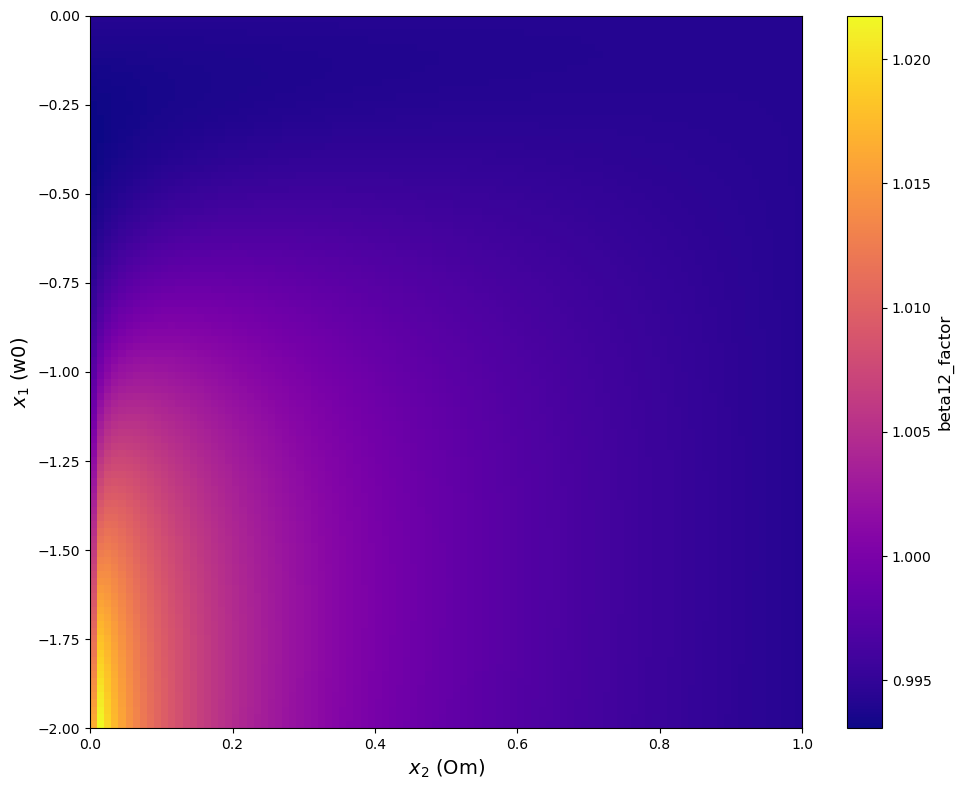

In [6]:
# Assume `w0_range` and `Om_range` are your x1 and x2 values
w0_range = np.linspace(-2, 0, 100)  # Replace with actual range
Om_range = np.linspace(0.0, 1.0, 100)  # Replace with actual range

# `beta12_values` is the 2D array computed from your code
beta12_factor_values = np.array([
    [
        (log_likelihood_beta12([x1, x2], z_l, z_s1, z_s2) /fiducial_beta12)[0]
        for x2 in Om_range
    ]
    for x1 in w0_range
])

print(np.min(beta12_factor_values))
print(np.max(beta12_factor_values))

# Create the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(beta12_factor_values, extent=[Om_range[0], Om_range[-1], w0_range[0], w0_range[-1]], 
           aspect='auto', origin='lower', cmap='plasma')

# Add colorbar
cbar = plt.colorbar()
cbar.set_label('beta12_factor', fontsize=12)

# Label axes
plt.xlabel('$x_2$ (Om)', fontsize=14)
plt.ylabel('$x_1$ (w0)', fontsize=14)

# Title
#plt.title('Heatmap of Log-Likelihood Ratio (beta12)', fontsize=16)

# Show plot
plt.tight_layout()
plt.show()

#### Test for Jackpot lens. The 1/beta output range matches with their posterior for 1/beta. Following plot suggested that they let distance ratios vary slight more than the range suggested by w0 and Omega_m range (see the Beta distribution in their Fig4)

1/fiducial_beta12_J09 1.408970430609841
0.6934650007515756
0.755847609320147


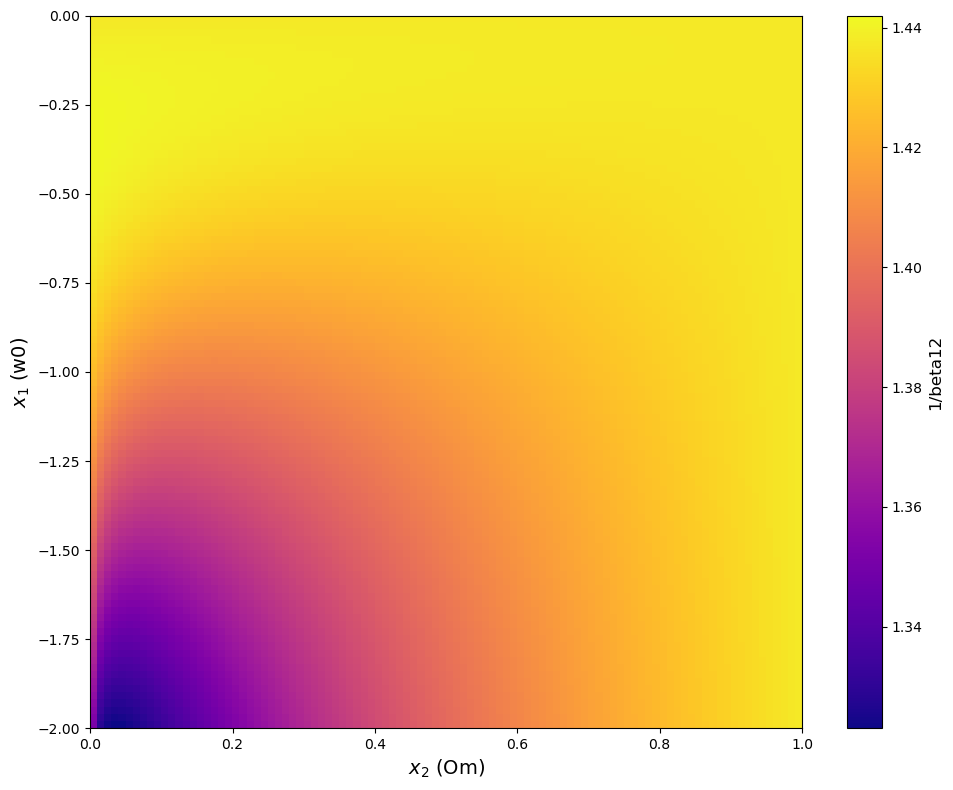

In [7]:
#calculation for Jacpot lens using redshifts from Collett et al. 2014
# Assume `w0_range` and `Om_range` are your x1 and x2 values
w0_range = np.linspace(-2, 0, 100)  # Replace with actual range
Om_range = np.linspace(0.0, 1.0, 100)  # Replace with actual range

cosmo = wCDM(H0=70, Om0=0.3, Ode0=0.7, w0=-1)  
d1_J09 = cosmo.angular_diameter_distance(z=0.222).value
d2_J09 = cosmo.angular_diameter_distance(z=0.609).value
d3_J09 = cosmo.angular_diameter_distance(z=2.35).value
d12_J09 = cosmo.angular_diameter_distance_z1z2(z1=0.222, z2=0.609).value
d13_J09 = cosmo.angular_diameter_distance_z1z2(z1=0.222, z2=2.35).value
d23_J09 = cosmo.angular_diameter_distance_z1z2(z1=0.609, z2=2.35).value
 


fiducial_beta12_J09=(d3_J09*d12_J09)/(d2_J09*d13_J09)
print("1/fiducial_beta12_J09",1/fiducial_beta12_J09)

# `beta12_values` is the 2D array computed from your code
beta12_values_J09 = np.array([
    [
        (log_likelihood_beta12([x1, x2], 0.222, 0.609, 2.35) )[0]
        for x2 in Om_range
    ]
    for x1 in w0_range
])

print(np.min(beta12_values_J09))
print(np.max(beta12_values_J09))

# Create the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(1/(beta12_values_J09), extent=[Om_range[0], Om_range[-1], w0_range[0], w0_range[-1]], 
           aspect='auto', origin='lower', cmap='plasma')

# Add colorbar
cbar = plt.colorbar()
cbar.set_label('1/beta12', fontsize=12)

# Label axes
plt.xlabel('$x_2$ (Om)', fontsize=14)
plt.ylabel('$x_1$ (w0)', fontsize=14)

# Title
#plt.title(' fhjk', fontsize=16)

# Show plot
plt.tight_layout()
plt.show()

### Read in distance ratio factors obtained/observed from Lens model

In [8]:
job_name_out = 'composite_F140W_5_2_Dist_Ratio_3_Beta_run01'  # DCLS1507_from_scratch_NFW_1_2_1_run_02
#cluster run
input_temp = os.path.join(base_path, 'midway_temp', job_name_out +'.txt')
output_temp = os.path.join(base_path, 'midway_temp', job_name_out +'_out.txt')
f = open(output_temp, 'rb')
[input_, output_] = joblib.load(f)
f.close()

fitting_kwargs_list, multi_band_list, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples = input_

kwargs_result, multi_band_list_out, fit_output, _ = output_

In [9]:
mcmc_out = [x for x in fit_output if x[0]=='emcee']
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = mcmc_out[0] #fit_output[2]
    
print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)

n, num_param = np.shape(samples_mcmc)
print("number of evaluations in the MCMC process: ", n)


number of non-linear parameters in the MCMC process:  38
parameters in order:  ['Rs_lens0', 'alpha_Rs_lens0', 'e1_lens0', 'e2_lens0', 'gamma_ext_lens1', 'psi_ext_lens1', 'theta_E_lens2', 'theta_E_lens3', 'alpha_1_lens4', 'theta_E_lens5', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'beta_source_light1', 'center_x_source_light1', 'center_y_source_light1', 'R_sersic_source_light2', 'n_sersic_source_light2', 'e1_source_light2', 'e2_source_light2', 'center_x_source_light2', 'center_y_source_light2', 'center_x_lens_light0', 'center_y_lens_light0', 'R_sersic_lens_light1', 'n_sersic_lens_light1', 'center_x_lens_light1', 'center_y_lens_light1', 'R_sersic_lens_light2', 'n_sersic_lens_light2', 'e1_lens_light2', 'e2_lens_light2', 'center_x_lens_light2', 'center_y_lens_light2', 'factor_beta_1_2']
number of evaluations in the MCMC process:  608000


### factor beta_12 histogram

##### When sampling distance ratios d1, d3, d13, and d23 are  fixed with fiducial cosmology. Thus only d2 and d12 are free, which are common in both a1 and a2. So we expect a correlation between a1 and a2. Thats why we are sampling only Beta (1/a1)

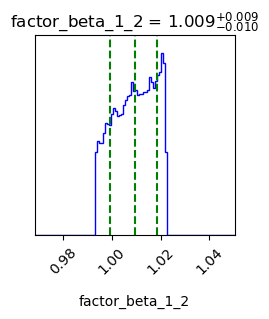

In [10]:
burnin_steps=1000*num_param*8

sample=samples_mcmc[0:,num_param-1:num_param] #discarding first 500,000
col_name=param_mcmc[num_param-1:num_param]
# Calculate the median for each parameter
medians = np.median(sample, axis=0)

# Set a fixed range around the median for each parameter (e.g., +/- 3 standard deviations or other range)
range_width = 5  # Adjust this value as needed for the width around the median
ranges = [
    (medians[i] - range_width * np.std(sample[:, i]), medians[i] + range_width * np.std(sample[:, i]))
    for i in range(sample.shape[1])
]

#percentile_bounds = [(np.percentile(sample[:, i], 0)*0.8, np.percentile(sample[:, i], 100)*1.2) for i in range(sample.shape[1])]

# Create the corner plot with the customized ranges
figure = corner.corner(
    sample,
    color='green',
    labels=col_name,
    title_quantiles=[0.16, 0.5, 0.84],
    title_fmt=".3f",
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    smooth=0.5,  # Adjust smoothing as needed
    #bins=20,
    range=ranges,  # Use custom ranges centered around the medians
    ##plot_density=True,
    #levels=[0.68, 0.95], #
    #contour_kwargs={"colors": "orange"},
    hist_kwargs={"color": "blue"},  # Set color of the histograms
    hist_bin_factor=5
)


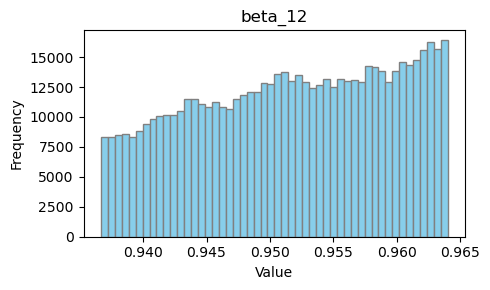

In [11]:
burnins=0 # 936000, burnin_steps
factor_beta_12=samples_mcmc[burnins:,num_param-1]
#factor_a_2=samples_mcmc[burnins:,num_param-1]

beta_12=factor_beta_12*fiducial_beta12


titles = [r'beta_12']
fig, axs = plt.subplots(1, 1, figsize=(5, 3))

# Plot the distributions
axs.hist(beta_12, bins=50, color='skyblue', edgecolor='gray')
axs.set_title(titles[0])

#axs[1].hist(a_2, bins=50, color='lightgreen', edgecolor='gray')
#axs[1].set_title(titles[1])

axs.set_xlabel('Value')
axs.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## mcmc sampling

### obtain log probability density function for the observed distance ratio Beta

In [12]:
beta12_samples=beta_12 #np.array([factor_beta_12] ) # two row and n columns
print(beta12_samples)

[0.94817094 0.96284634 0.94002711 ... 0.94206989 0.94265346 0.95948653]


In [13]:
beta12_samples=beta_12 #np.array([factor_beta_12] ) # two row and n columns
print(beta12_samples)
# obtain  mean_values_initial and cov_matrices for the observed combined samples

mean_beta12_samples = np.mean(beta12_samples) #mean of n values 
stdev_beta12_samples = np.std(beta12_samples)
variance_beta12_samples = np.var(beta12_samples) #, rowvar=False
display(Latex(f'Mean values: $\\beta_{{12}} = {mean_beta12_samples:.3f}_{{-{stdev_beta12_samples:.3f}}}^{{+{stdev_beta12_samples:.3f}}}$'))
print("variance about mean of beta12:", variance_beta12_samples)

median_beta12_samples = np.median(beta12_samples) #mean of n values 
err_beta_lower = median_beta12_samples - np.percentile(beta12_samples, 16)
err_beta_upper = np.percentile(beta12_samples, 84) - median_beta12_samples
display(Latex(f'Median values: $\\beta_{{12}} = {median_beta12_samples:.3f}_{{-{err_beta_lower:.3f}}}^{{+{err_beta_upper:.3f}}}$'))

# Compute the MAD (Median Absolute Deviation )
beta12_mad = np.median(np.abs(beta12_samples - median_beta12_samples))
beta12_sigma_mad = beta12_mad * 1.4826  # Scale MAD to standard deviation
# Approximate variance of the median
beta12_variance_median = beta12_sigma_mad ** 2  # the order of this value is similar to square of 1sigma bound about median.
#print(f"MAD: {beta12_mad}")
print(f"Variance about the median of beta12: {beta12_variance_median}")

# Create the log_probability function for the observed combined samples
log_prob_function_beta12 = make_log_probability_beta12(mean_beta12_samples, variance_beta12_samples, z_l, z_s1, z_s2)
#log_prob_function_a1 = make_log_probability_a1(median_a1_samples, variance_median, z_l, z_s1, z_s2)

print(log_prob_function_beta12)

[0.94817094 0.96284634 0.94002711 ... 0.94206989 0.94265346 0.95948653]


<IPython.core.display.Latex object>

variance about mean of beta12: 5.992380324405844e-05


<IPython.core.display.Latex object>

Variance about the median of beta12: 9.464176197476355e-05
function of parameters generated 
<function make_log_probability_beta12.<locals>.log_probability at 0x7f9be8726710>


### set up mcmc

In [14]:
# Set up the MCMC sampler
n_walkers =200 #200  # Fixed number of walkers
n_steps_mcmc =4000  #1000 # Number of steps per walker
n_dim = 2  # Number of dimensions (Omega_m and w0)

'''
# Mean values
mean_w0 = -1.0
mean_omega_m = 0.3
# Standard deviations to achieve the desired range
std_w0 = 0.3  # 0.1 To span -1.2 to -0.8 within two standard deviation
std_omega_m = 0.15  # 0.1 To span 0.1 to 0.5 within two standard deviation

# Construct the mean vector and covariance matrix
mean_w0_Om = np.array([mean_w0, mean_omega_m])
cov_matrix_w0_Om = np.array([[std_w0**2, 0], [0, std_omega_m**2]]) #no correlation between w0, omega_m

# Initialize the walkers initial position using a Gaussian distribution
pos = np.random.multivariate_normal(mean_w0_Om, cov_matrix_w0_Om, size=n_walkers)
'''

# Set the prior bounds
w0_min, w0_max = -2,0 #-2, 0  # Bounds for w0
omega_m_min, omega_m_max = 0, 1  # Bounds for Omega_m

pos = np.random.uniform(low=[w0_min, omega_m_min], high=[w0_max, omega_m_max], size=(n_walkers, n_dim))

# Set up the sampler
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_prob_function_beta12)


### run mcmc to constrain w0 and Omega_m using observed distance ratio pdfs

In [15]:
# Run the MCMC sampler
sampler.run_mcmc(pos, n_steps_mcmc, progress=True) #
print("mcmc ran successfully !!")

samples = sampler.get_chain(flat=True) #samples in 2D shape = (n_steps * n_walkers, n_params)
np.save(f'mcmc_samples_wCDM_{job_name_out}_mean.npy', samples)
print(f"Completed MCMC for {job_name_out}")

100%|██████████████████████████████████████████████████████████████| 4000/4000 [09:50<00:00,  6.77it/s]

mcmc ran successfully !!
Completed MCMC for composite_F140W_5_2_Dist_Ratio_3_Beta_run01


### Analyse mcmc results

In [15]:

# Retrieve the MCMC samples
#samples = sampler.get_chain(flat=True)

#samples=np.load('mcmc_samples_wCDM_DCLS1507_from_scratch_composite_F140W_5_2_Dist_Ratio_1_run00.npy')
samples=np.load(f'mcmc_samples_wCDM_{job_name_out}_mean.npy')

# Calculate median values and uncertainties
median_w0_model = np.median(samples[:, 0])
lower_w0, upper_w0 = np.percentile(samples[:, 0], [16, 84])
median_Omega_m_model = np.median(samples[:, 1])
lower_Omega_m, upper_Omega_m = np.percentile(samples[:, 1], [16, 84])


# Display the median values with uncertainties
display(Latex(f'Median values: $\Omega_m = {median_Omega_m_model:.3f}_{{-{median_Omega_m_model - lower_Omega_m:.3f}}}^{{+{upper_Omega_m - median_Omega_m_model:.3f}}}$'))
display(Latex(f'Median values: $w = {median_w0_model:.2f}_{{-{median_w0_model - lower_w0:.2f}}}^{{+{upper_w0 - median_w0_model:.2f}}}$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### plot mcmc chain

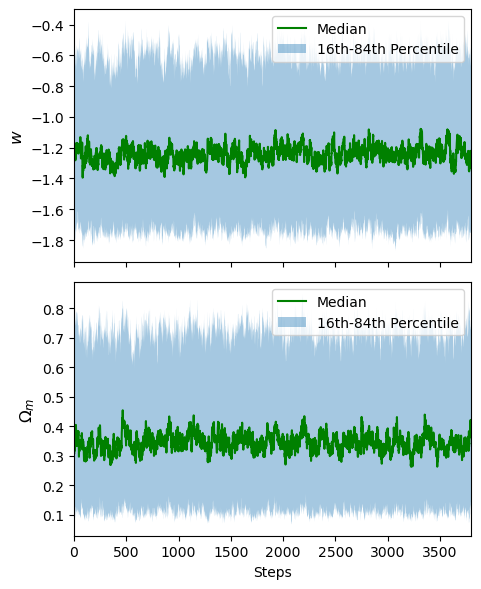

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [16]:
# Extract the MCMC samples and remove the burn-in phase
burn_in_steps =200 # 50 # Set this if you want to remove some steps as burn-in

#mcmc_samples = sampler.get_chain(flat=True)[burn_in_steps * n_walkers:] #remove burnin steps
#mcmc_samples=sampler.get_chain(flat=True)

mcmc_samples_AGEL1507=samples[burn_in_steps * n_walkers:]
mcmc_samples_3d = samples.reshape((n_steps_mcmc, n_walkers, -1))
#mcmc_samples=samples

# Check if there are any samples
if mcmc_samples_AGEL1507.size > 0:
    # Determine the number of parameters and steps
    n_params = mcmc_samples_AGEL1507.shape[1]
    chain = mcmc_samples_3d #sampler.get_chain()   ## 3D Shape: (n_steps_mcmc, n_walkers, n_params)
    chain = chain[burn_in_steps:]  # Discard burn-in if any
    n_steps = chain.shape[0]

    # Initialize arrays to store statistics
    mean_pos = np.zeros((n_params, n_steps))
    median_pos = np.zeros((n_params, n_steps))
    std_pos = np.zeros((n_params, n_steps))
    q16_pos = np.zeros((n_params, n_steps))
    q84_pos = np.zeros((n_params, n_steps))

    # Calculate statistics for each parameter at each step
    for i in range(n_params):
        for j in range(n_steps):
            mean_pos[i][j] = np.mean(chain[j, :, i])
            median_pos[i][j] = np.median(chain[j, :, i])
            std_pos[i][j] = np.std(chain[j, :, i])
            q16_pos[i][j] = np.percentile(chain[j, :, i], 16.)
            q84_pos[i][j] = np.percentile(chain[j, :, i], 84.)

    # Plotting the chains with median, and 16th-84th percentiles
    fig, ax = plt.subplots(n_params, sharex=True, figsize=(12, 6))
    param_names = [r"$w$", r"$\Omega_m$"]  # Adjust this if you have different parameters
    for i in range(n_params):
        ax[i].plot(median_pos[i], c='g', label='Median')
        ax[i].fill_between(np.arange(n_steps), q16_pos[i], q84_pos[i], alpha=0.4, label='16th-84th Percentile')
        ax[i].set_ylabel(param_names[i], fontsize=12)
        ax[i].legend()

    ax[-1].set_xlim(0, n_steps)
    ax[-1].set_xlabel('Steps')
    fig.set_size_inches((5, 3 * n_params)) #12., 5 * n_params
    plt.tight_layout()
    plt.show()

# save_path = f'{base_file_path2}{model}/mcmc_chain_plot.jpg'
# fig.savefig(save_path, dpi=300)

# Calculate median values and uncertainties
median_w0_model = np.median(mcmc_samples_AGEL1507[:, 0])
lower_w0, upper_w0 = np.percentile(mcmc_samples_AGEL1507[:, 0], [16, 84])
median_Omega_m_model = np.median(mcmc_samples_AGEL1507[:, 1])
lower_Omega_m, upper_Omega_m = np.percentile(mcmc_samples_AGEL1507[:, 1], [16, 84])

# Display the median values with uncertainties
display(Latex(f'Median values: $\Omega_m = {median_Omega_m_model:.3f}_{{-{median_Omega_m_model - lower_Omega_m:.3f}}}^{{+{upper_Omega_m - median_Omega_m_model:.3f}}}$'))
display(Latex(f'Median values: $w = {median_w0_model:.3f}_{{-{median_w0_model - lower_w0:.3f}}}^{{+{upper_w0 - median_w0_model:.3f}}}$'))


#### plot PDFs of w and Omega_m

Removed no burn in


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

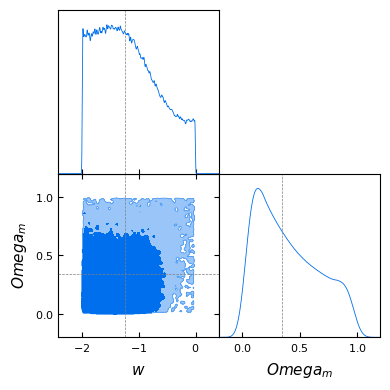

In [17]:
# Triangle plot using GetDist
param_names = ['w', 'omega_m']

gdsamples = MCSamples(samples=mcmc_samples_AGEL1507, names=param_names,labels=['w', 'Omega_m']) #, labels=[r"$w$", r"$\Omega_m$"] ,labels=['w', 'Omega_m']

g = plots.get_subplot_plotter()
fig = plt.figure(figsize=(15, 15))
range_limits = {'w': [-3.0, 0], 'omega_m': [0., 1]}  # Modify these ranges as needed

g.triangle_plot([gdsamples], filled=True, 
                markers={'w': median_w0_model, 'omega_m': median_Omega_m_model},
                contour_args={'alpha': 1.},
                limits=range_limits
               )  # Apply range limits here
# save_path_triangle = 'final_posterior_v2'
# plt.savefig(save_path_triangle, dpi=350, bbox_inches='tight')


# Manually set the axes limits if needed
#plt.xlim(range_limits['w'])
#plt.ylim(range_limits['omega_m'])


plt.close(fig)

#Display the median values with uncertainties
display(Latex(f'Median values: $\Omega_m = {median_Omega_m_model:.3f}_{{-{median_Omega_m_model - lower_Omega_m:.3f}}}^{{+{upper_Omega_m - median_Omega_m_model:.3f}}}$'))
display(Latex(f'Median values: $w = {median_w0_model:.3f}_{{-{median_w0_model - lower_w0:.3f}}}^{{+{upper_w0 - median_w0_model:.3f}}}$'))


### Lambda CDM Omega_m value

### mcmc

In [18]:
log_prob_function_beta12_lcdm = make_log_probability_beta12_lcdm(mean_beta12_samples, variance_beta12_samples, z_l, z_s1, z_s2)
#log_prob_function_a1_lcdm = make_log_probability_a1_lcdm(median_a1_samples, variance_median, z_l, z_s1, z_s2)

n_dim_lcdm=1 #only sampling Omega_m

#mean_0m=np.array([mean_omega_m])
#var_mean_0m=np.array([std_omega_m**2])
#pos_lcdm = np.random.normal(mean_0m, var_mean_0m, size=(n_walkers, n_dim_lcdm))

pos_lcdm = np.random.uniform(low=[omega_m_min], high=[omega_m_max], size=(n_walkers, n_dim_lcdm))
print(np.shape(pos_lcdm))

sampler_lcdm = emcee.EnsembleSampler(n_walkers, n_dim_lcdm, log_prob_function_beta12_lcdm)
print(sampler_lcdm)

function of parameters generated 
(200, 1)


In [31]:

sampler_lcdm.run_mcmc(pos_lcdm, n_steps_mcmc, progress=True) #
print("mcmc ran successfully !!")

mcmc_samples_lcdm = sampler_lcdm.get_chain(flat=True)
np.save(f'mcmc_samples_LCDM_{job_name_out}_mean.npy', mcmc_samples_lcdm)

100%|██████████████████████████████████████████████████████████████| 4000/4000 [11:12<00:00,  5.95it/s]


mcmc ran successfully !!


### plot mcmc

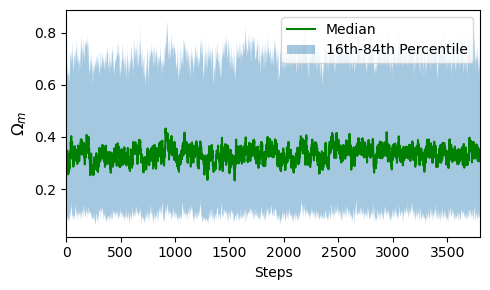

<IPython.core.display.Latex object>

In [19]:
# Extract the MCMC samples and remove the burn-in phase
burn_in_steps_lcdm = 200  # Set this if you want to remove some steps as burn-in

#mcmc_samples_LCDM_DCLS1507_from_scratch_composite_F140W_5_2_Dist_Ratio_1_run00
samples_lcdm=np.load(f'mcmc_samples_LCDM_{job_name_out}_mean.npy')

#mcmc_samples_lcdm = sampler_lcdm.get_chain(flat=True)[burn_in_steps_lcdm * n_walkers:]

mcmc_samples_lcdm_AGEL1507=samples_lcdm[burn_in_steps_lcdm * n_walkers:]
mcmc_samples_lcdm_3d = samples_lcdm.reshape((n_steps_mcmc, n_walkers, -1))
# Check if there are any samples
if mcmc_samples_lcdm_AGEL1507.size > 0:
    # Determine the number of parameters and steps
    n_params = 1  # Since n_params is fixed to 1
    chain = mcmc_samples_lcdm_3d  #sampler_lcdm.get_chain()  # Shape: (n_steps_mcmc, n_walkers, n_params)
    chain = chain[burn_in_steps_lcdm:]  # Discard burn-in if any
    n_steps = chain.shape[0]

    # Initialize arrays to store statistics
    mean_pos = np.zeros((n_steps,))
    median_pos = np.zeros((n_steps,))
    std_pos = np.zeros((n_steps,))
    q16_pos = np.zeros((n_steps,))
    q84_pos = np.zeros((n_steps,))

    # Calculate statistics for the parameter at each step
    for j in range(n_steps):
        mean_pos[j] = np.mean(chain[j, :, 0])
        median_pos[j] = np.median(chain[j, :, 0])
        std_pos[j] = np.std(chain[j, :, 0])
        q16_pos[j] = np.percentile(chain[j, :, 0], 16.)
        q84_pos[j] = np.percentile(chain[j, :, 0], 84.)

    # Plotting the chain with median, and 16th-84th percentiles
    fig, ax = plt.subplots(figsize=(12, 6))  # Only one parameter, so no subplots
    param_name = r"$\Omega_m$"  # Adjust this if you have a different parameter

    ax.plot(median_pos, c='g', label='Median')
    ax.fill_between(np.arange(n_steps), q16_pos, q84_pos, alpha=0.4, label='16th-84th Percentile')
    ax.set_ylabel(param_name, fontsize=12)
    ax.legend()

    ax.set_xlim(0, n_steps)
    ax.set_xlabel('Steps')
    fig.set_size_inches((5, 3))  # Adjust the figure size for one parameter
    plt.tight_layout()
    plt.show()

# save_path = f'{base_file_path2}{model}/mcmc_chain_plot.jpg'
# fig.savefig(save_path, dpi=300)

# Calculate median values and uncertainties
median_Omega_m_lcdm = np.median(mcmc_samples_lcdm_AGEL1507)
lower_Omega_m_lcdm, upper_Omega_m_lcdm = np.percentile(mcmc_samples_lcdm_AGEL1507, [16, 84])

# Display the median values with uncertainties
display(Latex(f'Median values: $\Omega_m = {median_Omega_m_lcdm:.3f}_{{-{median_Omega_m_lcdm - lower_Omega_m_lcdm:.3f}}}^{{+{upper_Omega_m_lcdm - median_Omega_m_lcdm:.3f}}}$'))


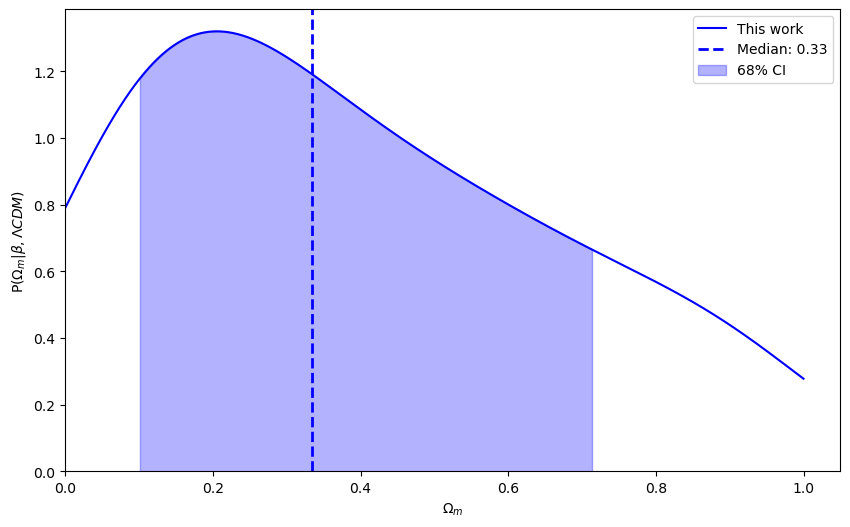

In [20]:
#mcmc_samples_lcdm=samples_lcdm[burn_in_steps_lcdm * n_walkers:]
n_samples = len(mcmc_samples_lcdm_AGEL1507)

mcmc_samples_lcdm_kde=mcmc_samples_lcdm_AGEL1507
if n_samples > 5000:
    mcmc_samples_lcdm_kde = np.random.choice(mcmc_samples_lcdm_kde.flatten(), 5000, replace=False)


x_val = np.linspace(min(mcmc_samples_lcdm_kde), max(mcmc_samples_lcdm_kde), 2000)

#bw_method: The method used to calculate the estimator bandwidth.  This can be 'scott', 'silverman', a scalar constant or a callable
kde_this_work= gaussian_kde(mcmc_samples_lcdm_kde, bw_method=0.5) #bw_method=0.2

pdf_this_work=kde_this_work(x_val)

# Create the plot
plt.figure(figsize=(10, 6))
# Add labels and title
# Plot each individual PDF
plt.plot(x_val, pdf_this_work, label='This work', color='blue')
#plt.plot(lcdm_median_Om*np.ones(5),np.linspace(0,1.82,5),color='blue')
plt.axvline(x=median_Omega_m_lcdm, color='blue', linestyle='--', linewidth=2, label=f'Median: {median_Omega_m_lcdm:.2f}')

# Fill the 68% confidence interval under each PDF
plt.fill_between(x_val, pdf_this_work, where=(x_val >= lower_Omega_m_lcdm) &
                 (x_val <= upper_Omega_m_lcdm), 
                 color='blue', alpha=0.3, label='68% CI') #'68% CI (This work)'
plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"P$(\Omega_m | \beta, \Lambda CDM)$")
#plt.title('Probability Distribution Plot')

# Change axis limits to include origin (0,0)
plt.xlim(left=0)  # Adjust the left limit of x-axis as needed
plt.ylim(bottom=0)  # Adjust the bottom limit of y-axis as needed
plt.legend()

#plt.savefig(f'/Users/nandinisahu/Library/CloudStorage/OneDrive-UNSW/AGEL/Paper_DSPL/{job_name_out}_AGEL1507_LCDM.pdf', dpi=1200)

plt.show()

#### using obtaining LCDM sample from wo--omega_m 2D distribution

In [21]:
def get_LCDM_from_wCDM_chain(w_values, Om_values, target_w_value=-1, tol=1e-4):
    # Convert to numpy arrays if they are not already
    Om_values = np.array(Om_values)
    w_values = np.array(w_values)
    
    # Use a tolerance for matching
    mask = np.abs(w_values - target_w_value) < tol
    # Apply the additional conditions Om > min_Om_value and Om < max_Om_value
    filtered_Om_values = Om_values[mask]
    
    # Calculate median and 68% confidence interval
    median_Om = np.median(filtered_Om_values) if len(filtered_Om_values) > 0 else np.nan    
    lower_median_Om, upper_median_Om = np.percentile(filtered_Om_values, [16, 84]) if len(filtered_Om_values) > 0 else np.nan
    
    # Calculate mean and standard deviation
    
    mean_Om = np.mean(filtered_Om_values) if len(filtered_Om_values) > 0 else np.nan
    std_Om = np.std(filtered_Om_values) if len(filtered_Om_values) > 0 else np.nan  
    
    return mean_Om, std_Om, median_Om, lower_median_Om, upper_median_Om, filtered_Om_values


### Checking and Quantifying skewness

In [22]:
'''
Om_sample=mcmc_samples_AGEL1507[:, 1]
# Fit the skewed normal distribution to data
alpha_hat, loc, scale = skewnorm.fit(Om_sample)
# Estimated parameters
print("for Omega_m \n")
print(f"Estimated skewness (alpha): {alpha_hat}")
print(f"Estimated location (mean): {loc}")
print(f"Estimated scale (std dev): {scale}")
#Positive skewness indicates right (positive) skew (meaning peak will be in the leftleft)
skewness = skew(Om_sample) #skewness coefficient.
print(f"Skewness of the data: {skewness}")

w0_sample=mcmc_samples_AGEL1507[:, 0]
# Fit the skewed normal distribution to data
alpha_hat1, loc1, scale1 = skewnorm.fit(w0_sample)
# Estimated parameters
print("for w0 \n")
print(f"Estimated skewness (alpha): {alpha_hat1}")
print(f"Estimated location (mean): {loc1}")
print(f"Estimated scale (std dev): {scale1}")

#Positive skewness indicates right (positive) skew (meaning peak will be in the leftleft)
skewness1 = skew(w0_sample) #skewness coefficient.
print(f"Skewness of the data: {skewness1}")
'''

'\nOm_sample=mcmc_samples_AGEL1507[:, 1]\n# Fit the skewed normal distribution to data\nalpha_hat, loc, scale = skewnorm.fit(Om_sample)\n# Estimated parameters\nprint("for Omega_m \n")\nprint(f"Estimated skewness (alpha): {alpha_hat}")\nprint(f"Estimated location (mean): {loc}")\nprint(f"Estimated scale (std dev): {scale}")\n#Positive skewness indicates right (positive) skew (meaning peak will be in the leftleft)\nskewness = skew(Om_sample) #skewness coefficient.\nprint(f"Skewness of the data: {skewness}")\n\nw0_sample=mcmc_samples_AGEL1507[:, 0]\n# Fit the skewed normal distribution to data\nalpha_hat1, loc1, scale1 = skewnorm.fit(w0_sample)\n# Estimated parameters\nprint("for w0 \n")\nprint(f"Estimated skewness (alpha): {alpha_hat1}")\nprint(f"Estimated location (mean): {loc1}")\nprint(f"Estimated scale (std dev): {scale1}")\n\n#Positive skewness indicates right (positive) skew (meaning peak will be in the leftleft)\nskewness1 = skew(w0_sample) #skewness coefficient.\nprint(f"Skewnes

#### Collett et al. 2014

In [23]:
'''
# Create the plot
plt.figure(figsize=(10, 6))

Om_lcdm_Collett=np.random.normal(0.33,0.33,1000)
sns.kdeplot(Om_lcdm_Collett, fill=False, color='black', label='Collett+14')

# Add labels and title
plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"P$(\Omega_m | \beta, \Lambda CDM)$")
#plt.title('Probability Distribution Plot')

# Change axis limits to include origin (0,0)
plt.xlim(left=0)  # Adjust the left limit of x-axis as needed
plt.ylim(bottom=0)  # Adjust the bottom limit of y-axis as needed
plt.legend()
# Show the plot
plt.show()
'''

'\n# Create the plot\nplt.figure(figsize=(10, 6))\n\nOm_lcdm_Collett=np.random.normal(0.33,0.33,1000)\nsns.kdeplot(Om_lcdm_Collett, fill=False, color=\'black\', label=\'Collett+14\')\n\n# Add labels and title\nplt.xlabel(r"$\\Omega_m$")\nplt.ylabel(r"P$(\\Omega_m | \x08eta, \\Lambda CDM)$")\n#plt.title(\'Probability Distribution Plot\')\n\n# Change axis limits to include origin (0,0)\nplt.xlim(left=0)  # Adjust the left limit of x-axis as needed\nplt.ylim(bottom=0)  # Adjust the bottom limit of y-axis as needed\nplt.legend()\n# Show the plot\nplt.show()\n'

### Beta from Collett et al. 2014

In [24]:
beta_collett=0.712 
uncer_beta_collett=0.008
var_beta_collett=0.008**2

a1_collett=1/0.712 
print('a1_collett',a1_collett)
uncer_a1_collett=abs(- 0.008/(0.712**2)) 
print('uncer_a1_collett',uncer_a1_collett)
var_a1_collett=uncer_a1_collett**2
print('var_a1_collett',var_a1_collett)

z_l_jackpot = 0.222
z_s1_jackpot = 0.609
z_s2_jackpot = 2.035 

z_s2_old_jackpot = 2.4 #2.35 2.3 Collett+2014

a1_collett 1.404494382022472
uncer_a1_collett 0.015780835753061485
var_a1_collett 0.00024903477706510364


In [25]:
# Create the log_probability function for the observed combined samples
log_prob_beta12_collett = make_log_probability_beta12(beta_collett, var_beta_collett, z_l_jackpot, z_s1_jackpot, z_s2_jackpot)
print(log_prob_beta12_collett)

# Set up the sampler
sampler_collett = emcee.EnsembleSampler(n_walkers, n_dim, log_prob_beta12_collett)
# Run the MCMC sampler
pos1=pos  # same as our 2D mcmc run

function of parameters generated 
<function make_log_probability_beta12.<locals>.log_probability at 0x7f9bd83103a0>


In [39]:
sampler_collett.run_mcmc(pos1, n_steps_mcmc, progress=True) #
print("mcmc ran successfully !!")

mcmc_samples_collett = sampler_collett.get_chain(flat=True)
np.save('mcmc_samples_collett_wCDM_new_z_s2.npy', mcmc_samples_collett)

100%|██████████████████████████████████████████████████████████████| 4000/4000 [10:03<00:00,  6.63it/s]

mcmc ran successfully !!


### plot mcmc 

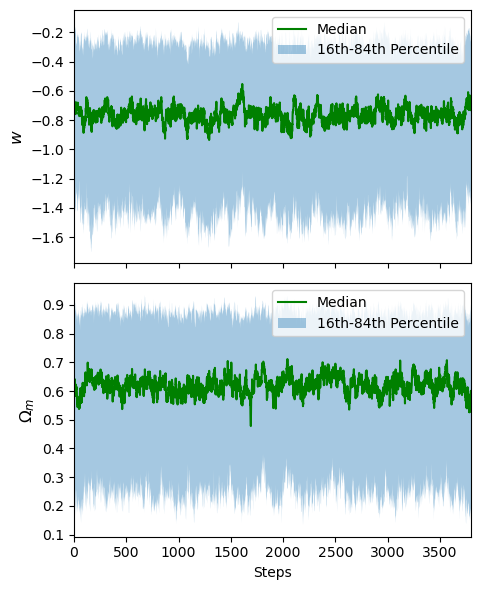

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [26]:
# Extract the MCMC samples and remove the burn-in phase
burn_in_steps = 200 # Set this if you want to remove some steps as burn-in
#mcmc_samples_collett = sampler_collett.get_chain(flat=True)[burn_in_steps * n_walkers:]

samples_collett=np.load('mcmc_samples_collett_wCDM_new_z_s2.npy')

#mcmc_samples_lcdm = sampler_lcdm.get_chain(flat=True)[burn_in_steps_lcdm * n_walkers:]
mcmc_samples_collett=samples_collett[burn_in_steps_lcdm * n_walkers:]
mcmc_samples_collett_3d = samples_collett.reshape((n_steps_mcmc, n_walkers, -1))

# Check if there are any samples
if mcmc_samples_collett.size > 0:
    # Determine the number of parameters and steps
    n_params = mcmc_samples_collett.shape[1]
    chain2 = mcmc_samples_collett_3d #sampler_collett.get_chain()  # Shape: (n_steps_mcmc, n_walkers, n_params)
    chain2 = chain2[burn_in_steps:]  # Discard burn-in if any
    n_steps = chain2.shape[0]

    # Initialize arrays to store statistics
    mean_pos_collett  = np.zeros((n_params, n_steps))
    median_pos_collett  = np.zeros((n_params, n_steps))
    std_pos_collett  = np.zeros((n_params, n_steps))
    q16_pos_collett  = np.zeros((n_params, n_steps))
    q84_pos_collett  = np.zeros((n_params, n_steps))

    # Calculate statistics for each parameter at each step
    for i in range(n_params):
        for j in range(n_steps):
            mean_pos_collett[i][j] = np.mean(chain2[j, :, i])
            median_pos_collett[i][j] = np.median(chain2[j, :, i])
            std_pos_collett[i][j] = np.std(chain2[j, :, i])
            q16_pos_collett[i][j] = np.percentile(chain2[j, :, i], 16.)
            q84_pos_collett[i][j] = np.percentile(chain2[j, :, i], 84.)

    # Plotting the chains with median, and 16th-84th percentiles
    fig, ax = plt.subplots(n_params, sharex=True, figsize=(12, 6))
    param_names = [r"$w$", r"$\Omega_m$"]  # Adjust this if you have different parameters
    for i in range(n_params):
        ax[i].plot(median_pos_collett[i], c='g', label='Median')
        ax[i].fill_between(np.arange(n_steps), q16_pos_collett[i], q84_pos_collett[i], alpha=0.4, label='16th-84th Percentile')
        ax[i].set_ylabel(param_names[i], fontsize=12)
        ax[i].legend()

    ax[-1].set_xlim(0, n_steps)
    ax[-1].set_xlabel('Steps')
    fig.set_size_inches((5, 3 * n_params)) #12., 5 * n_params
    plt.tight_layout()
    plt.show()

# save_path = f'{base_file_path2}{model}/mcmc_chain_plot.jpg'
# fig.savefig(save_path, dpi=300)

# Calculate median values and uncertainties
median_w0_model_collett = np.median(mcmc_samples_collett[:, 0])
lower_w0_collett, upper_w0_collett = np.percentile(mcmc_samples_collett[:, 0], [16, 84])
median_Omega_m_model_collett = np.median(mcmc_samples_collett[:, 1])
lower_Omega_m_collett, upper_Omega_m_collett = np.percentile(mcmc_samples_collett[:, 1], [16, 84])

# Display the median values with uncertainties
display(Latex(f'Median values: $\Omega_m = {median_Omega_m_model_collett:.3f}_{{-{median_Omega_m_model_collett - lower_Omega_m_collett:.3f}}}^{{+{upper_Omega_m_collett - median_Omega_m_model_collett:.3f}}}$'))
display(Latex(f'Median values: $w = {median_w0_model_collett:.2f}_{{-{median_w0_model_collett - lower_w0:.2f}}}^{{+{upper_w0_collett - median_w0_model_collett:.2f}}}$'))


plotting Jackpot lens constraints
Removed no burn in


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

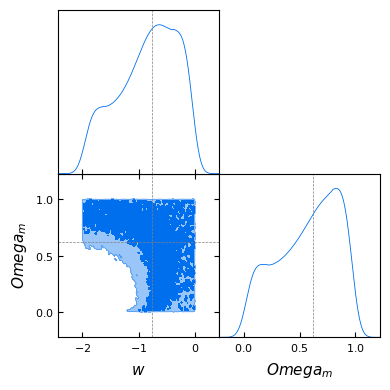

In [27]:
# Triangle plot using GetDist
print('plotting Jackpot lens constraints')
param_names = ['w', 'omega_m']

gdsamples = MCSamples(samples=mcmc_samples_collett, names=param_names,labels=['w', 'Omega_m']) #, labels=[r"$w$", r"$\Omega_m$"] ,labels=['w', 'Omega_m']

g = plots.get_subplot_plotter()
fig = plt.figure(figsize=(15, 15))
range_limits = {'w': [-3.0, 0], 'omega_m': [0., 1]}  # Modify these ranges as needed

g.triangle_plot([gdsamples], filled=True, 
                markers={'w': median_w0_model_collett, 'omega_m': median_Omega_m_model_collett},
                contour_args={'alpha': 1.},
                limits=range_limits
               )  # Apply range limits here
# save_path_triangle = 'final_posterior_v2'
# plt.savefig(save_path_triangle, dpi=350, bbox_inches='tight')
plt.close(fig)

# Display the median values with uncertainties
display(Latex(f'Median values: $\Omega_m = {median_Omega_m_model_collett:.3f}_{{-{median_Omega_m_model_collett - lower_Omega_m_collett:.3f}}}^{{+{upper_Omega_m_collett - median_Omega_m_model_collett:.3f}}}$'))
display(Latex(f'Median values: $w = {median_w0_model_collett:.3f}_{{-{median_w0_model_collett - lower_w0:.3f}}}^{{+{upper_w0_collett - median_w0_model_collett:.3f}}}$'))

In [28]:
log_prob_function_beta12_lcdm_collett = make_log_probability_beta12_lcdm(beta_collett, var_beta_collett, z_l_jackpot, 
                                                                         z_s1_jackpot, z_s2_jackpot)
n_dim_lcdm=1 #only sampling Omega_m

sampler_lcdm_collett  = emcee.EnsembleSampler(n_walkers, n_dim_lcdm, log_prob_function_beta12_lcdm_collett)
print(sampler_lcdm_collett )

function of parameters generated 


In [43]:
sampler_lcdm_collett.run_mcmc(pos_lcdm, n_steps_mcmc, progress=True) #
print("mcmc ran successfully !!")

mcmc_samples_lcdm_collett = sampler_lcdm_collett.get_chain(flat=True)
np.save(f'mcmc_samples_LCDM_collett_new_z_s2.npy', mcmc_samples_lcdm_collett)

100%|██████████████████████████████████████████████████████████████| 4000/4000 [11:18<00:00,  5.90it/s]

mcmc ran successfully !!


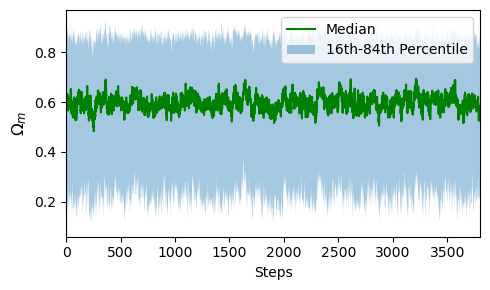

<IPython.core.display.Latex object>

In [29]:
# Extract the MCMC samples and remove the burn-in phase
burn_in_steps_lcdm = 200  # Set this if you want to remove some steps as burn-in

#mcmc_samples_lcdm = sampler_lcdm.get_chain(flat=True)[burn_in_steps_lcdm * n_walkers:]
samples_lcdm_collett=np.load('mcmc_samples_LCDM_collett_new_z_s2.npy')

#mcmc_samples_lcdm = sampler_lcdm.get_chain(flat=True)[burn_in_steps_lcdm * n_walkers:]
mcmc_samples_lcdm_collett=samples_lcdm_collett[burn_in_steps_lcdm * n_walkers:]
mcmc_samples_lcdm_collett_3d = samples_lcdm_collett.reshape((n_steps_mcmc, n_walkers, -1))


# Check if there are any samples
if mcmc_samples_lcdm_collett.size > 0:
    # Determine the number of parameters and steps
    n_params = 1  # Since n_params is fixed to 1
    chain = mcmc_samples_lcdm_collett_3d #sampler_lcdm_collett.get_chain()  # Shape: (n_steps_mcmc, n_walkers, n_params)
    chain = chain[burn_in_steps_lcdm:]  # Discard burn-in if any
    n_steps = chain.shape[0]

    # Initialize arrays to store statistics
    mean_pos = np.zeros((n_steps,))
    median_pos = np.zeros((n_steps,))
    std_pos = np.zeros((n_steps,))
    q16_pos = np.zeros((n_steps,))
    q84_pos = np.zeros((n_steps,))

    # Calculate statistics for the parameter at each step
    for j in range(n_steps):
        mean_pos[j] = np.mean(chain[j, :, 0])
        median_pos[j] = np.median(chain[j, :, 0])
        std_pos[j] = np.std(chain[j, :, 0])
        q16_pos[j] = np.percentile(chain[j, :, 0], 16.)
        q84_pos[j] = np.percentile(chain[j, :, 0], 84.)

    # Plotting the chain with median, and 16th-84th percentiles
    fig, ax = plt.subplots(figsize=(12, 6))  # Only one parameter, so no subplots
    param_name = r"$\Omega_m$"  # Adjust this if you have a different parameter

    ax.plot(median_pos, c='g', label='Median')
    ax.fill_between(np.arange(n_steps), q16_pos, q84_pos, alpha=0.4, label='16th-84th Percentile')
    ax.set_ylabel(param_name, fontsize=12)
    ax.legend()

    ax.set_xlim(0, n_steps)
    ax.set_xlabel('Steps')
    fig.set_size_inches((5, 3))  # Adjust the figure size for one parameter
    plt.tight_layout()
    plt.show()

# save_path = f'{base_file_path2}{model}/mcmc_chain_plot.jpg'
# fig.savefig(save_path, dpi=300)

# Calculate median values and uncertainties
median_Omega_m_lcdm_collett = np.median(mcmc_samples_lcdm_collett)
lower_Omega_m_lcdm_collett, upper_Omega_m_lcdm_collett = np.percentile(mcmc_samples_lcdm_collett, [16, 84])

# Display the median values with uncertainties
display(Latex(f'Median values: $\Omega_m = {median_Omega_m_lcdm_collett:.3f}_{{-{median_Omega_m_lcdm_collett - lower_Omega_m_lcdm_collett:.3f}}}^{{+{upper_Omega_m_lcdm_collett - median_Omega_m_lcdm_collett:.3f}}}$'))


# Planck CMB chain (from Anowar)

In [30]:
planck = None

for i in range(1, 5):
    if planck is None:
        planck = np.loadtxt(f"planck_chain/base_w_plikHM_TT_lowl_lowE_{i}.txt")
    else:
        planck = np.vstack(
            (planck, np.loadtxt(f"planck_chain/base_w_plikHM_TT_lowl_lowE_{i}.txt"))
        )

# planck = np.loadtxt("data/fwcdm_planck.txt", )

print(planck.shape)

planck_slice = planck[:, [26, 6]]
# planck_slice = planck[:, [1, 7]]

params = [r"$w$", r"$\Omega_\text{m}$"]

planck_df = DataFrame(planck_slice, columns=params)

planck_slice.shape

(40188, 90)


(40188, 2)

In [31]:
swapped_planck_slice = planck_slice[:, [1, 0]]

median_w0_planck = np.median(swapped_planck_slice[:, 0])
lower_w0_planck, upper_w0_planck = np.percentile(swapped_planck_slice[:, 0], [16, 84])
median_Omega_m_planck = np.median(swapped_planck_slice[:, 1])
lower_Omega_m_planck, upper_Omega_m_planck= np.percentile(swapped_planck_slice[:, 1], [16, 84])

#Display the median values with uncertainties
display(Latex(f'Planck Median values  : $w = {median_w0_planck:.3f}_{{-{median_w0_planck - lower_w0_planck:.3f}}}^{{+{upper_w0_planck - median_w0_planck:.3f}}}$'))
display(Latex(f'Planck Median values: $\Omega_m = {median_Omega_m_planck:.3f}_{{-{median_Omega_m_planck - lower_Omega_m_planck:.3f}}}^{{+{upper_Omega_m_planck - median_Omega_m_planck:.3f}}}$'))



<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## SNe I data

In [32]:
sn_lcdm = np.loadtxt("des_sn5yr_lcdm.txt")
chain_sn_lcdm = np.reshape(sn_lcdm, (-1, 48, 4))
converged_chain_sn_lcdm = chain_sn_lcdm[250::10, :, :1]
samples_sn_lcdm = converged_chain_sn_lcdm.reshape((-1, 1))

flat_samples_sn_lcdm=np.array(samples_sn_lcdm).ravel().tolist()
flat_samples_sn_lcdm=np.array(flat_samples_sn_lcdm)

flat_samples_sn_lcdm.shape

(8400,)

In [33]:
median_w0_sn_lcdm = np.median(flat_samples_sn_lcdm)
lower_w0_sn_lcdm, upper_w0_sn_lcdm = np.percentile(flat_samples_sn_lcdm, [16, 84])
display(Latex(f'SNe Median values: $\Omega_m = {median_w0_sn_lcdm:.3f}_{{-{median_w0_sn_lcdm - lower_w0_sn_lcdm:.3f}}}^{{+{upper_w0_sn_lcdm - median_w0_sn_lcdm:.3f}}}$'))

<IPython.core.display.Latex object>

In [34]:
sn_wcdm = np.loadtxt("des_sn5yr_wcdm_2.txt")
chain_sn_wcdm = np.reshape(sn_wcdm, (-1, 48, 5))
converged_chain_sn_wcdm= chain_sn_wcdm[250::10, :, :2]
samples_sn_wcdm = converged_chain_sn_wcdm.reshape((-1, 2))
#flat_samples_sn_wcdm=[item for sublist in samples_sn_wcdm for item in sublist]
samples_sn_wcdm.shape

(8400, 2)

In [35]:
median_w0_sn_wcdm = np.median(samples_sn_wcdm[:,1])
lower_w0_sn_wcdm, upper_w0_sn_wcdm = np.percentile(samples_sn_wcdm[:,1], [16, 84])
median_Omega_m_sn_wcdm = np.median(samples_sn_wcdm[:,0])
lower_Omega_m_sn_wcdm, upper_Omega_m_sn_wcdm= np.percentile(samples_sn_wcdm[:,0], [16, 84])

#Display the median values with uncertainties
display(Latex(f'SNe Median values  : $w = {median_w0_sn_wcdm:.3f}_{{-{median_w0_sn_wcdm - lower_w0_sn_wcdm:.3f}}}^{{+{upper_w0_sn_wcdm - median_w0_sn_wcdm:.3f}}}$'))
display(Latex(f'SNe Median values: $\Omega_m = {median_Omega_m_sn_wcdm:.3f}_{{-{median_Omega_m_sn_wcdm - lower_Omega_m_sn_wcdm:.3f}}}^{{+{upper_Omega_m_sn_wcdm - median_Omega_m_sn_wcdm:.3f}}}$'))


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## BAO data

In [36]:
bao_lcdm = np.loadtxt("desi_lcdm.txt")
chain_bao_lcdm = np.reshape(bao_lcdm, (-1, 48, 4))
converged_chain_bao_lcdm = chain_bao_lcdm[200::10, :, :1]

samples_bao_lcdm = converged_chain_bao_lcdm.reshape((-1, 1))
flat_samples_bao_lcdm=np.array(samples_bao_lcdm).ravel().tolist()
flat_samples_bao_lcdm=np.array(flat_samples_bao_lcdm)
flat_samples_bao_lcdm.shape

(8640,)

In [37]:
median_w0_bao_lcdm = np.median(flat_samples_bao_lcdm)
lower_w0_bao_lcdm, upper_w0_bao_lcdm = np.percentile(flat_samples_bao_lcdm, [16, 84])
display(Latex(f'BAO Median values: $\Omega_m = {median_w0_bao_lcdm:.3f}_{{-{median_w0_bao_lcdm - lower_w0_bao_lcdm:.3f}}}^{{+{upper_w0_bao_lcdm - median_w0_bao_lcdm:.3f}}}$'))

<IPython.core.display.Latex object>

In [38]:
bao_wcdm = np.loadtxt("desi_wcdm_2.txt")
chain_bao_wcdm = np.reshape(bao_wcdm, (-1, 48, 5))
converged_chain_bao_wcdm = chain_bao_wcdm[200::10, :, :2]

samples_bao_wcdm = converged_chain_bao_wcdm.reshape((-1, 2))
samples_bao_wcdm.shape
#flat_samples_bao_wcdm=np.array(samples_bao_wcdm).ravel().tolist()

(8640, 2)

In [39]:
median_w0_bao_wcdm = np.median(samples_bao_wcdm[:,1])
lower_w0_bao_wcdm, upper_w0_bao_wcdm = np.percentile(samples_bao_wcdm[:,1], [16, 84])
median_Omega_m_bao_wcdm = np.median(samples_bao_wcdm[:,0])

lower_Omega_m_bao_wcdm, upper_Omega_m_bao_wcdm = np.percentile(samples_bao_wcdm[:,0], [16, 84])

# Display the median values with uncertainties
display(Latex(f'BAO Median values  : $w = {median_w0_bao_wcdm:.3f}_{{-{median_w0_bao_wcdm - lower_w0_bao_wcdm:.3f}}}^{{+{upper_w0_bao_wcdm - median_w0_bao_wcdm:.3f}}}$'))
display(Latex(f'BAO Median values: $\Omega_m = {median_Omega_m_bao_wcdm:.3f}_{{-{median_Omega_m_bao_wcdm - lower_Omega_m_bao_wcdm:.3f}}}^{{+{upper_Omega_m_bao_wcdm - median_Omega_m_bao_wcdm:.3f}}}$'))


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

# Combined Constraints

### Flat Lambda CDM case

### AGEL1507 + J09

<IPython.core.display.Latex object>

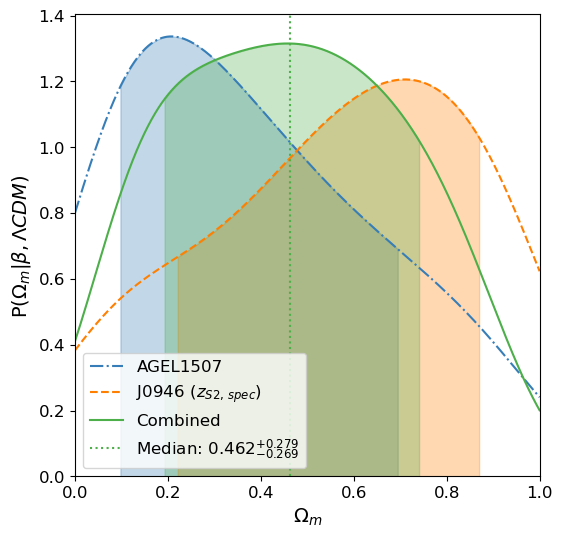

In [40]:
#n_samples = len(mcmc_samples_lcdm_AGEL1507) 
if len(mcmc_samples_lcdm_AGEL1507) > 5000:
    mcmc_samples_lcdm_AGEL1507_kde = np.random.choice(mcmc_samples_lcdm_AGEL1507.flatten(), 5000, replace=False)

    
#n_samples2 = len(mcmc_samples_lcdm_collett)
if len(mcmc_samples_lcdm_collett) > 5000:
    mcmc_samples_lcdm_collett_kde = np.random.choice(mcmc_samples_lcdm_collett.flatten(), 5000, replace=False)

# Generate data from two normal distributions
data1 = mcmc_samples_lcdm_AGEL1507_kde #np.random.normal(0.33, 0.26, 1000)  # First distribution
#num =len(mcmc_samples_lcdm_AGEL1507_kde)
#data1=np.random.normal(0.337, 0.33, num) 
data2 = mcmc_samples_lcdm_collett_kde #np.random.normal(0.33, 0.26, 1000)  # 2sigma=2*0.26

# Create Kernel Density Estimates for both datasets
kde1 = gaussian_kde(data1, bw_method=0.5)
kde2 = gaussian_kde(data2,  bw_method=0.5)

# X values for which to evaluate the PDFs
x_vals = np.linspace(min(data1.min(), data2.min()), max(data1.max(), data2.max()), 1000)

# Evaluate the KDEs (PDFs) for both datasets
pdf1 = kde1(x_vals)
pdf2 = kde2(x_vals)

# Combine PDFs by multiplying them pointwise
pdf_combined = pdf1 * pdf2

# Normalize the combined PDF to ensure it integrates to 1
normalization_factor = np.trapz(pdf_combined, x_vals)  # Trapezoidal integration
pdf_combined /= normalization_factor

# Calculate the cumulative distribution function (CDF) for each PDF
cdf1 = np.cumsum(pdf1) * np.diff(x_vals)[0]  # CDF for PDF 1
cdf2 = np.cumsum(pdf2) * np.diff(x_vals)[0]  # CDF for PDF 2
cdf_combined = np.cumsum(pdf_combined) * np.diff(x_vals)[0]  # CDF for combined PDF


# Find the 68% confidence interval (16th to 84th percentile)
conf_68_low_1, conf_68_high_1 = np.percentile(data1, [16, 84])  # 68% CI for PDF 1
conf_68_low_2, conf_68_high_2 = np.percentile(data2, [16, 84])  # 68% CI for PDF 2
# Find the 68% confidence interval for the combined PDF
cdf_comb_values = np.interp([0.16, 0.84], cdf_combined, x_vals)  # Inverse CDF for combined PDF
conf_68_low_combined, conf_68_high_combined = cdf_comb_values  # 68% CI for combined PDF

median_combined_Om = np.interp(0.5, cdf_combined, x_vals)  # Interpolate to find the median
e_conf_68_low_combined=median_combined_Om-conf_68_low_combined
e_conf_68_high_combined=conf_68_high_combined-median_combined_Om

display(Latex(f'Combined Median values and 16 to 84 percentile (68%) : $\Omega_m = {median_combined_Om:.3f}_{{-{e_conf_68_low_combined:.3f}}}^{{+{e_conf_68_high_combined:.3f}}}$'))


# Plot the original and combined PDFs
plt.figure(figsize=(6, 6))

# Plot each individual PDF
plt.plot(x_vals, pdf1, label='AGEL1507', color='#377eb8',linewidth=1.5,linestyle='-.') #DCLS1507 AGEL1507

plt.plot(x_vals, pdf2, label=r'J0946 ($z_{S2,\, spec}$)', color='#ff7f00',linewidth=1.5,linestyle='--')

# Plot the combined PDF
plt.plot(x_vals, pdf_combined, label='Combined', color='#4daf4a',linewidth=1.5)

plt.axvline(x=median_combined_Om, color='#4daf4a',linestyle='dotted',label=f'Median: ${median_combined_Om:.3f}^{{+{e_conf_68_high_combined:.3f}}}_{{-{e_conf_68_low_combined:.3f}}}$')
#plt.axvline(x=median_Omega_m_lcdm, color='blue', linestyle='--', linewidth=2, label=f'Median: {median_Omega_m_lcdm:.3f}')


# Fill the 68% confidence interval under each PDF
plt.fill_between(x_vals, pdf1, where=(x_vals >= conf_68_low_1) & (x_vals <= conf_68_high_1), 
                 color=CB_color_cycle['blue'], alpha=0.3, label=None) #'68% CI (This work)'
plt.fill_between(x_vals, pdf2, where=(x_vals >= conf_68_low_2) & (x_vals <= conf_68_high_2), 
                 color=CB_color_cycle['orange'], alpha=0.3, label=None) #'68% CI (Collett+14)'

# Fill the 68% confidence interval for the combined PDF
plt.fill_between(x_vals, pdf_combined, where=(x_vals >= conf_68_low_combined) & (x_vals <= conf_68_high_combined),
                 color=CB_color_cycle['green'], alpha=0.3, label=None) #'68% CI (Combined)'

# Add labels

# Add labels
plt.xlabel(r"$\Omega_m$",fontsize=14)
plt.ylabel(r"P$(\Omega_m | \beta, \Lambda CDM)$",fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Adjust axis limits
#plt.xlim(left=0)  # Ensure x-axis starts at 0
#plt.ylim(bottom=0)  # Ensure y-axis starts at 0
# Adjust axis limits
plt.xlim(0, 1)  # Restrict x-axis between 0 and 1
plt.ylim(bottom=0)  # Ensure y-axis starts at 0

# Add legend
plt.legend(fontsize=12)

plt.savefig(f'/Users/nandinisahu/Library/CloudStorage/OneDrive-UNSW/AGEL/Paper_DSPL/{job_name_out}_Om_PDF_DSPL_combined.pdf', dpi=1200)


# Show the plot
plt.show()


### combining with old Jackpot lens constraints (for a test)

<IPython.core.display.Latex object>

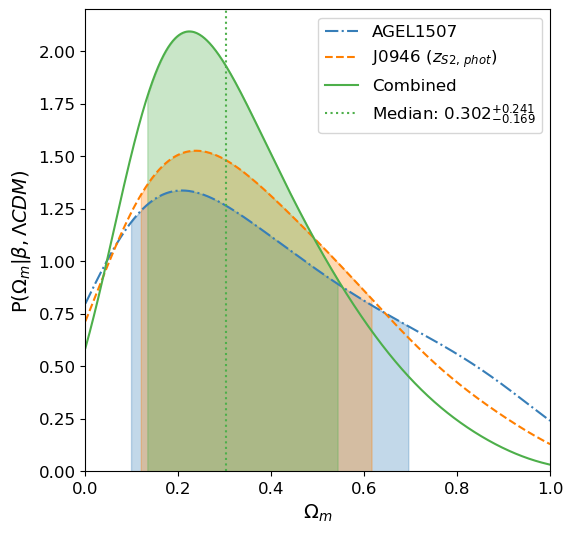

In [41]:
samples_lcdm_collett_zS2_phot=np.load('mcmc_samples_LCDM_collett_beta12_old_zs2_2point4.npy')


if len(samples_lcdm_collett_zS2_phot) > 5000:
    samples_lcdm_collett_zS2_phot_kde = np.random.choice(samples_lcdm_collett_zS2_phot.flatten(), 5000, replace=False)
else:
    samples_lcdm_collett_zS2_phot_kde = samples_lcdm_collett_zS2_phot

# Assigning KDE samples to new variables
data_AGEL1507 = mcmc_samples_lcdm_AGEL1507_kde
data_Collett_zS2_phot = samples_lcdm_collett_zS2_phot_kde

# Create Kernel Density Estimates (KDE)
kde_AGEL1507 = gaussian_kde(data_AGEL1507, bw_method=0.5)
kde_Collett_zS2_phot = gaussian_kde(data_Collett_zS2_phot, bw_method=0.5)

# Define the range for evaluation
x_vals2 = np.linspace(min(data_AGEL1507.min(), data_Collett_zS2_phot.min()), 
                      max(data_AGEL1507.max(), data_Collett_zS2_phot.max()), 
                      1000)

# Evaluate KDEs
pdf_AGEL1507_2 = kde_AGEL1507(x_vals2)
pdf_Collett_zS2_phot = kde_Collett_zS2_phot(x_vals2)

# Compute the combined PDF by multiplying individual PDFs
pdf_combined_DSPLs_2 = pdf_AGEL1507_2 * pdf_Collett_zS2_phot

# Normalize the combined PDF
normalization_factor_2 = np.trapz(pdf_combined_DSPLs_2, x_vals2)  # Trapezoidal integration
pdf_combined_DSPLs_2 /= normalization_factor_2

# Compute CDFs
cdf_AGEL1507_2 = np.cumsum(pdf_AGEL1507_2) * np.diff(x_vals2)[0]
cdf_Collett_zS2_phot_2 = np.cumsum(pdf_Collett_zS2_phot) * np.diff(x_vals2)[0]
cdf_combined_DSPLs_2 = np.cumsum(pdf_combined_DSPLs_2) * np.diff(x_vals2)[0]

# Compute 68% confidence intervals (16th to 84th percentile)
conf_68_low_AGEL1507_2, conf_68_high_AGEL1507_2 = np.percentile(data_AGEL1507, [16, 84])
conf_68_low_Collett_zS2_phot, conf_68_high_Collett_zS2_phot = np.percentile(data_Collett_zS2_phot, [16, 84])

# 68% confidence interval for combined PDF
cdf_comb_values_2 = np.interp([0.16, 0.84], cdf_combined_DSPLs_2, x_vals2)
conf_68_low_combined_2, conf_68_high_combined_2 = cdf_comb_values_2

# Compute median and uncertainties
median_combined_Om_2 = np.interp(0.5, cdf_combined_DSPLs_2, x_vals2)
e_conf_68_low_combined_2 = median_combined_Om_2 - conf_68_low_combined_2
e_conf_68_high_combined_2 = conf_68_high_combined_2 - median_combined_Om_2

# Display results
display(Latex(f'Combined Median values and 16 to 84 percentile (68%) : '
              f'$\Omega_m = {median_combined_Om_2:.3f}_{{-{e_conf_68_low_combined_2:.3f}}}^{{+{e_conf_68_high_combined_2:.3f}}}$'))

# Plot the PDFs
plt.figure(figsize=(6, 6))

# Plot KDE PDFs
plt.plot(x_vals2, pdf_AGEL1507_2, label='AGEL1507', color='#377eb8', linewidth=1.5,linestyle='-.')

plt.plot(x_vals2, pdf_Collett_zS2_phot, label=r'J0946 ($z_{S2,\, phot}$)', color='#ff7f00', linewidth=1.5,linestyle='--')

# Plot combined PDF
plt.plot(x_vals2, pdf_combined_DSPLs_2, label='Combined', color='#4daf4a', linewidth=1.5)

# Plot median line
plt.axvline(x=median_combined_Om_2, color='#4daf4a', linestyle='dotted', 
            label=f'Median: ${median_combined_Om_2:.3f}^{{+{e_conf_68_high_combined_2:.3f}}}_{{-{e_conf_68_low_combined_2:.3f}}}$')

# Fill 68% confidence intervals
plt.fill_between(x_vals2, pdf_AGEL1507_2, where=(x_vals2 >= conf_68_low_AGEL1507_2) & (x_vals2 <= conf_68_high_AGEL1507_2), 
                 color='#377eb8', alpha=0.3, label=None)
plt.fill_between(x_vals2, pdf_Collett_zS2_phot, where=(x_vals2 >= conf_68_low_Collett_zS2_phot) & (x_vals2 <= conf_68_high_Collett_zS2_phot), 
                 color='#ff7f00', alpha=0.3, label=None)
plt.fill_between(x_vals2, pdf_combined_DSPLs_2, where=(x_vals2 >= conf_68_low_combined_2) & (x_vals2 <= conf_68_high_combined_2),
                 color='#4daf4a', alpha=0.3, label=None) #'68% CI (Combined)'

# Labels and legend
plt.xlabel(r"$\Omega_m$", fontsize=14)
plt.ylabel(r"P$(\Omega_m | \beta, \Lambda CDM)$", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Adjust axis limits
plt.xlim(0, 1)  # Restrict x-axis between 0 and 1
plt.ylim(bottom=0)  # Ensure y-axis starts at 0
plt.legend(fontsize=12)

# Save and show the plot
plt.savefig(f'/Users/nandinisahu/Library/CloudStorage/OneDrive-UNSW/AGEL/Paper_DSPL/{job_name_out}_Om_PDF_DSPL_combined_J09_zS2_phot.pdf', dpi=1200)
plt.show()


### All in one

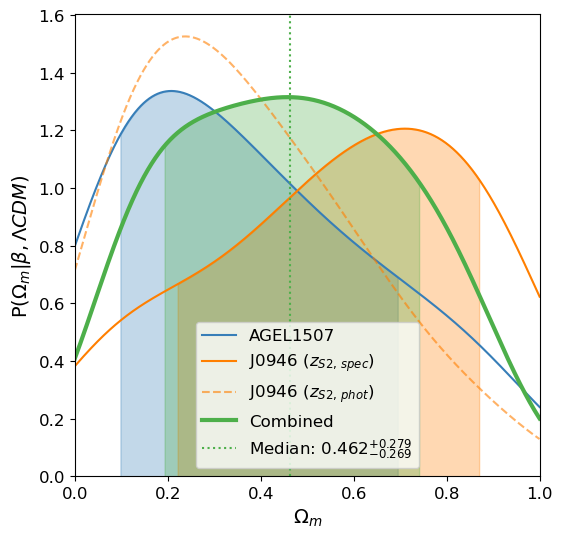

In [42]:

# Plot the original and combined PDFs
plt.figure(figsize=(6, 6))

# Plot each individual PDF
plt.plot(x_vals, pdf1, label='AGEL1507', color='#377eb8',linewidth=1.5,linestyle='-') #DCLS1507 AGEL1507

plt.plot(x_vals, pdf2, label=r'J0946 ($z_{S2,\, spec}$)', color='#ff7f00',linewidth=1.5,linestyle='-')

plt.plot(x_vals2, pdf_Collett_zS2_phot, label=r'J0946 ($z_{S2,\, phot}$)', color='#ff7f00', 
         linewidth=1.5,linestyle='--', alpha=0.6)

# Plot the combined PDF
plt.plot(x_vals, pdf_combined, label='Combined', color='#4daf4a',linewidth=3)

plt.axvline(x=median_combined_Om, color='#4daf4a',linestyle='dotted',label=f'Median: ${median_combined_Om:.3f}^{{+{e_conf_68_high_combined:.3f}}}_{{-{e_conf_68_low_combined:.3f}}}$')
#plt.axvline(x=median_Omega_m_lcdm, color='blue', linestyle='--', linewidth=2, label=f'Median: {median_Omega_m_lcdm:.3f}')


# Fill the 68% confidence interval under each PDF
plt.fill_between(x_vals, pdf1, where=(x_vals >= conf_68_low_1) & (x_vals <= conf_68_high_1), 
                 color=CB_color_cycle['blue'], alpha=0.3, label=None) #'68% CI (This work)'
plt.fill_between(x_vals, pdf2, where=(x_vals >= conf_68_low_2) & (x_vals <= conf_68_high_2), 
                 color=CB_color_cycle['orange'], alpha=0.3, label=None) #'68% CI (Collett+14)'
#plt.fill_between(x_vals, pdf_Collett_zS2_phot, where=(x_vals >= conf_68_low_Collett_zS2_phot) & (x_vals <= conf_68_high_Collett_zS2_phot), 
#                 color='#ff7f00', alpha=0.3, label=None)

# Fill the 68% confidence interval for the combined PDF
plt.fill_between(x_vals, pdf_combined, where=(x_vals >= conf_68_low_combined) & (x_vals <= conf_68_high_combined),
                 color=CB_color_cycle['green'], alpha=0.3, label=None) #'68% CI (Combined)'

# Add labels

# Add labels
plt.xlabel(r"$\Omega_m$",fontsize=14)
plt.ylabel(r"P$(\Omega_m | \beta, \Lambda CDM)$",fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Adjust axis limits
#plt.xlim(left=0)  # Ensure x-axis starts at 0
#plt.ylim(bottom=0)  # Ensure y-axis starts at 0
# Adjust axis limits
plt.xlim(0, 1)  # Restrict x-axis between 0 and 1
plt.ylim(bottom=0)  # Ensure y-axis starts at 0

# Add legend
plt.legend(fontsize=12)

plt.savefig(f'/Users/nandinisahu/Library/CloudStorage/OneDrive-UNSW/AGEL/Paper_DSPL/{job_name_out}_Om_PDF_DSPL_combined_J09_both_zS2.pdf', dpi=1200)

# Show the plot
plt.show()


In [43]:
# Testing if the combined PDF integrates to 1
integral_combined = np.trapz(pdf_combined, x_vals)  # Numerical integration
print(f"Integral of combined PDF: {integral_combined:.6f}")

# Assert to check if it's close to 1
assert np.isclose(integral_combined, 1.0, atol=1e-6), "Combined PDF is not normalized!"


Integral of combined PDF: 1.000000


### AGEL1507 + J09 +CMB

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

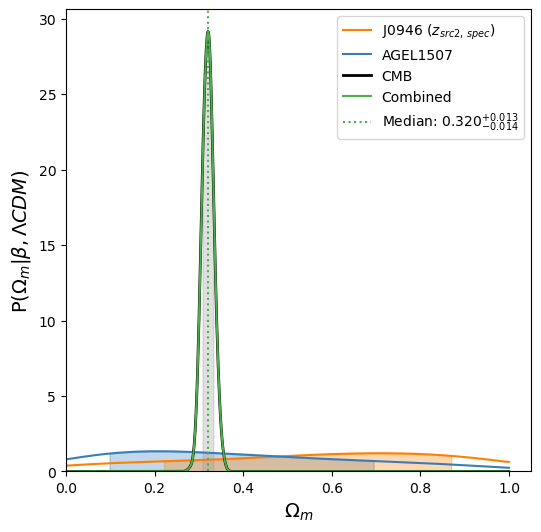

In [44]:
planck_w_values= planck_slice[:, [1, 0]][:,0]
planck_Om_values= planck_slice[:, [1, 0]][:,1]
planck_lcdm_mean_Om, planck_lcdm_std_Om, planck_lcdm_median_Om, planck_lcdm_lower_median_Om, planck_lcdm_upper_median_Om, planck_lcdm_filtered_Om_values=get_LCDM_from_wCDM_chain(planck_w_values, planck_Om_values, target_w_value=-1, tol=1e-2)
#print(planck_lcdm_filtered_Om_values)
display(Latex(f'Median values: $\Omega_m = {planck_lcdm_median_Om:.3f}_{{-{planck_lcdm_median_Om - planck_lcdm_lower_median_Om:.3f}}}^{{+{planck_lcdm_upper_median_Om - planck_lcdm_median_Om:.3f}}}$'))

Planck_lcdm_data=planck_lcdm_filtered_Om_values


kde3=gaussian_kde(Planck_lcdm_data,  bw_method=0.5)
#mcmc_samples_lcdm_AGEL1507_kde mcmc_samples_lcdm_collett_kde
# X values for which to evaluate the PDFs
x_vals1 = np.linspace(min(mcmc_samples_lcdm_AGEL1507_kde.min(), mcmc_samples_lcdm_collett_kde.min(), Planck_lcdm_data.min()), max(data1.max(), data2.max(),Planck_lcdm_data.max()), 1000)

# Evaluate the KDEs (PDFs) for both datasets
pdf_AGEL = kde1(x_vals1)
pdf_J09 = kde2(x_vals1)
pdf_planck=kde3(x_vals1)

# Combine PDFs by multiplying them pointwise
pdf_combined_lcdm = pdf_AGEL * pdf_J09* pdf_planck

# Normalize the combined PDF to ensure it integrates to 1
normalization_factor1 = np.trapz(pdf_combined_lcdm, x_vals1)  # Trapezoidal integration
pdf_combined_lcdm /= normalization_factor1

# Calculate the cumulative distribution function (CDF) for each PDF
cdf_AGEL = np.cumsum(pdf_AGEL) * np.diff(x_vals1)[0]  # CDF for PDF 1
cdf_J09 = np.cumsum(pdf_J09) * np.diff(x_vals1)[0]  # CDF for PDF 2
cdf_planck = np.cumsum(pdf_planck) * np.diff(x_vals1)[0]  # CDF for PDF 3
cdf_combined_lcdm = np.cumsum(pdf_combined_lcdm) * np.diff(x_vals1)[0]  # CDF for combined PDF

# Find the 68% confidence interval (16th to 84th percentile)
conf_68_low_1, conf_68_high_1 = np.percentile(data1, [16, 84])  # 68% CI for PDF 1
conf_68_low_2, conf_68_high_2 = np.percentile(data2, [16, 84])  # 68% CI for PDF 2
conf_68_low_3, conf_68_high_3 = np.percentile(Planck_lcdm_data, [16, 84])  # 68% CI for PDF 3

# Find the 68% confidence interval for the combined PDF
cdf_comb_values_lcdm = np.interp([0.16, 0.84], cdf_combined_lcdm, x_vals1)  # Inverse CDF for combined PDF
conf_68_low_combined_lcdm, conf_68_high_combined_lcdm = cdf_comb_values_lcdm  # 68% CI for combined PDF

median_combined_Om_lcdm = np.interp(0.5, cdf_combined_lcdm, x_vals1)  # Interpolate to find the median
e_conf_68_low_combined_lcdm=median_combined_Om_lcdm-conf_68_low_combined_lcdm
e_conf_68_high_combined_lcdm=conf_68_high_combined_lcdm-median_combined_Om_lcdm

display(Latex(f'Combined Median values and 16 to 84 percentile (68%) : $\Omega_m = {median_combined_Om_lcdm:.3f}_{{-{e_conf_68_low_combined_lcdm:.3f}}}^{{+{e_conf_68_high_combined_lcdm:.3f}}}$'))


# Plot the original and combined PDFs
plt.figure(figsize=(6, 6))

# Plot each individual PDF
plt.plot(x_vals1, pdf_J09, label=r'J0946 ($z_{src2,\, spec}$)', color='#ff7f00')
plt.plot(x_vals1, pdf_AGEL, label='AGEL1507', color='#377eb8') #DCLS1507 AGEL1507
plt.plot(x_vals1, pdf_planck, label='CMB', color='black', linewidth=2)

# Plot the combined PDF
plt.plot(x_vals1, pdf_combined_lcdm, label='Combined', color='#4daf4a')

plt.axvline(x=median_combined_Om_lcdm, color='#4daf4a',linestyle='dotted',label=f'Median: ${median_combined_Om_lcdm:.3f}^{{+{e_conf_68_low_combined_lcdm:.3f}}}_{{-{e_conf_68_high_combined_lcdm:.3f}}}$')
#plt.axvline(x=median_Omega_m_lcdm, color='blue', linestyle='--', linewidth=2, label=f'Median: {median_Omega_m_lcdm:.3f}')


# Fill the 68% confidence interval under each PDF
plt.fill_between(x_vals1, pdf_AGEL, where=(x_vals1 >= conf_68_low_1) & (x_vals1 <= conf_68_high_1), 
                 color=CB_color_cycle['blue'], alpha=0.3, label=None) #'68% CI (This work)'
plt.fill_between(x_vals1, pdf_J09, where=(x_vals1 >= conf_68_low_2) & (x_vals1 <= conf_68_high_2), 
                 color=CB_color_cycle['orange'], alpha=0.3, label=None) #'68% CI (Collett+14)'

plt.fill_between(x_vals1, pdf_planck, where=(x_vals1 >= conf_68_low_3) & (x_vals1 <= conf_68_high_3), 
                 color=CB_color_cycle['gray'], alpha=0.3, label=None) #'68% CI (Collett+14)'

plt.xlabel(r"$\Omega_m$",fontsize=14)
plt.ylabel(r"P$(\Omega_m | \beta, \Lambda CDM)$",fontsize=14)

# Adjust axis limits
plt.xlim(left=0)  # Ensure x-axis starts at 0
plt.ylim(bottom=0)  # Ensure y-axis starts at 0

# Add legend
plt.legend()

plt.savefig(f'/Users/nandinisahu/Library/CloudStorage/OneDrive-UNSW/AGEL/Paper_DSPL/{job_name_out}_Om_PDF_DSPL_CMB_combined.pdf', dpi=1200)

# Show the plot
plt.show()


### DSPLs + CMB + SNe + BAO

<IPython.core.display.Latex object>

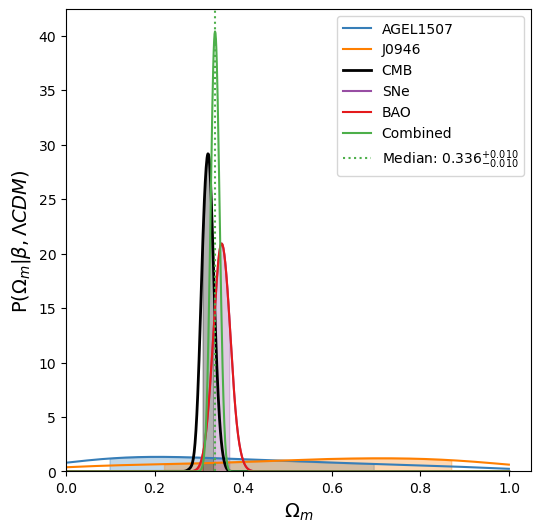

In [45]:
kde4=gaussian_kde(np.array(flat_samples_sn_lcdm),  bw_method=0.5)
kde5=gaussian_kde(np.array(flat_samples_sn_lcdm),  bw_method=0.5)

# X values for which to evaluate the PDFs
x_vals3 = np.linspace(
    min(mcmc_samples_lcdm_AGEL1507_kde.min(), mcmc_samples_lcdm_collett_kde.min(), Planck_lcdm_data.min(), flat_samples_sn_lcdm.min(), flat_samples_bao_lcdm.min()), 
    max(mcmc_samples_lcdm_AGEL1507_kde.max(), mcmc_samples_lcdm_collett_kde.max(), Planck_lcdm_data.max(), flat_samples_sn_lcdm.max(), flat_samples_bao_lcdm.max()), 
    1000
)

# Evaluate the KDEs (PDFs) for all datasets
pdf_A = kde1(x_vals3)
pdf_B = kde2(x_vals3)
pdf_C = kde3(x_vals3)
pdf_D = kde4(x_vals3)
pdf_E = kde5(x_vals3)

# Combine PDFs by multiplying them pointwise
pdf_combined_all = pdf_A * pdf_B * pdf_C * pdf_D * pdf_E

# Normalize the combined PDF to ensure it integrates to 1
normalization_factor3 = np.trapz(pdf_combined_all, x_vals3)  # Trapezoidal integration
pdf_combined_all /= normalization_factor3

# Calculate the cumulative distribution function (CDF) for each PDF
cdf_A = np.cumsum(pdf_A) * np.diff(x_vals3)[0]  
cdf_B = np.cumsum(pdf_B) * np.diff(x_vals3)[0]  
cdf_C = np.cumsum(pdf_C) * np.diff(x_vals3)[0]  
cdf_D = np.cumsum(pdf_D) * np.diff(x_vals3)[0]  
cdf_E = np.cumsum(pdf_E) * np.diff(x_vals3)[0]  
cdf_combined_all = np.cumsum(pdf_combined_all) * np.diff(x_vals3)[0]  

# Find the 68% confidence interval (16th to 84th percentile)
conf_68_low_A, conf_68_high_A = np.percentile(mcmc_samples_lcdm_AGEL1507_kde, [16, 84])
conf_68_low_B, conf_68_high_B = np.percentile(mcmc_samples_lcdm_collett_kde, [16, 84])
conf_68_low_C, conf_68_high_C = np.percentile(Planck_lcdm_data, [16, 84])
conf_68_low_D, conf_68_high_D = np.percentile(flat_samples_sn_lcdm, [16, 84])
conf_68_low_E, conf_68_high_E = np.percentile(flat_samples_bao_lcdm, [16, 84])

# Find the 68% confidence interval for the combined PDF
cdf_comb_values_all = np.interp([0.16, 0.84], cdf_combined_all, x_vals3)  
conf_68_low_combined_all, conf_68_high_combined_all = cdf_comb_values_all  

median_combined_Om_all = np.interp(0.5, cdf_combined_all, x_vals3)  
e_conf_68_low_combined_all = median_combined_Om_all - conf_68_low_combined_all
e_conf_68_high_combined_all = conf_68_high_combined_all - median_combined_Om_all

display(Latex(
    f'Combined Median values and 16 to 84 percentile (68%) : '
    f'$\\Omega_m = {median_combined_Om_all:.3f}_{{-{e_conf_68_low_combined_all:.3f}}}^'
    f'{{+{e_conf_68_high_combined_all:.3f}}}$'
))

# Plot the original and combined PDFs
plt.figure(figsize=(6, 6))

# Plot each individual PDF
plt.plot(x_vals3, pdf_A, label='AGEL1507', color='#377eb8')
plt.plot(x_vals3, pdf_B, label='J0946', color='#ff7f00')
plt.plot(x_vals3, pdf_C, label='CMB', color='black', linewidth=2)
plt.plot(x_vals3, pdf_D, label='SNe', color='#984ea3')
plt.plot(x_vals3, pdf_E, label='BAO', color='#e41a1c')

# Plot the combined PDF
plt.plot(x_vals3, pdf_combined_all, label='Combined', color='#4daf4a')

plt.axvline(
    x=median_combined_Om_all, 
    color='#4daf4a', linestyle='dotted', 
    label=f'Median: ${median_combined_Om_all:.3f}^{{+{e_conf_68_low_combined_all:.3f}}}_{{-{e_conf_68_high_combined_all:.3f}}}$'
)

# Fill the 68% confidence interval under each PDF
plt.fill_between(
    x_vals3, pdf_A, where=(x_vals3 >= conf_68_low_A) & (x_vals3 <= conf_68_high_A), 
    color='#377eb8', alpha=0.3
)
plt.fill_between(
    x_vals3, pdf_B, where=(x_vals3 >= conf_68_low_B) & (x_vals3 <= conf_68_high_B), 
    color='#ff7f00', alpha=0.3
)
plt.fill_between(
    x_vals3, pdf_C, where=(x_vals3 >= conf_68_low_C) & (x_vals3 <= conf_68_high_C), 
    color='black', alpha=0.3
)
plt.fill_between(
    x_vals3, pdf_D, where=(x_vals3 >= conf_68_low_D) & (x_vals3 <= conf_68_high_D), 
    color='#984ea3', alpha=0.3
)
plt.fill_between(
    x_vals3, pdf_E, where=(x_vals3 >= conf_68_low_E) & (x_vals3 <= conf_68_high_E), 
    color='#e41a1c', alpha=0.3
)

plt.xlabel(r"$\Omega_m$", fontsize=14)
plt.ylabel(r"P$(\Omega_m | \beta, \Lambda CDM)$", fontsize=14)

# Adjust axis limits
plt.xlim(left=0)
plt.ylim(bottom=0)

# Add legend
plt.legend()

plt.savefig(f'/Users/nandinisahu/Library/CloudStorage/OneDrive-UNSW/AGEL/Paper_DSPL/{job_name_out}_Om_PDF_ALL_combined.pdf', dpi=1200)

# Show the plot
plt.show()


## Flat wCDM case

### ploting  constraints

Removed no burn in


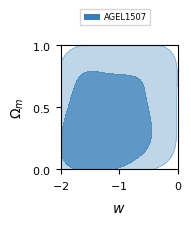

In [46]:
#samples_dcls1507 = np.load(f'mcmc_samples_wCDM_{job_name_out}_mean.npy')
# Parameter names and LaTeX labels
param_names = ['w', 'omega_m']
param_labels =[r"w", r"\Omega_m"]  # LaTeX labels

# First set of samples
gdsamples1 = MCSamples(samples=mcmc_samples_AGEL1507, names=param_names, labels=param_labels)
gdsamples1.updateSettings({'fine_bins_2D': 80, 'smooth_scale_2D': 0.5})  # Higher bin count & smoothing


# GetDist plotter
g = plots.get_subplot_plotter()
fig = plt.figure(figsize=(15, 15))

# Plot only the 2D distribution with filled contours for both datasets
g.plot_2d([gdsamples1], param1='w', param2='omega_m', filled=True, 
          fine_bins=80,  # Higher bin count
          colors=[CB_color_cycle['blue']], #['#377eb8', '#ff7f00'], 
          alphas=[0.8], 
          smooth_scale_2D=0.5  # Apply KDE smoothing
         )
# Optionally, apply limits

range_limits = {'w': [-2.0, 0], 'omega_m': [0., 1]}  # Adjust ranges as needed
g.set_axes(param_limits=range_limits) #[gdsamples1, gdsamples2],


ax = plt.gca()  # Get the current axes

# Manually set the axes limits if needed
plt.xlim(range_limits['w'])
plt.ylim(range_limits['omega_m'])

# Set axes labels
ax.set_xlabel(r"$w$", fontsize=10)  # X-axis label
ax.set_ylabel(r"$\Omega_m$", fontsize=10)  # Y-axis label


# Add custom legend for red and blue
legend_elements = [
    Patch(facecolor=CB_color_cycle['blue'], label='AGEL1507'), #edgecolor='black'
]

# Add the legend to the plot
#ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1.32), fancybox=False, shadow=False, ncol=1, fontsize=6)
ax.legend(handles=legend_elements, bbox_to_anchor=(0.8, 1.32), fancybox=False, shadow=False,
          ncol=1, fontsize=6, handletextpad=0.4, columnspacing=0.5)

#ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1.32), fancybox=False, shadow=False,
#          ncol=2, fontsize=6, handletextpad=0.4, columnspacing=0.5) #(1.12, 1.35)

plt.savefig(f'/Users/nandinisahu/Library/CloudStorage/OneDrive-UNSW/AGEL/Paper_DSPL/{job_name_out}_AGEL1507_wCDM.pdf', dpi=1200, bbox_inches='tight')

plt.close(fig)

## Combined KDE for 2D distributions (Using multiplication method)

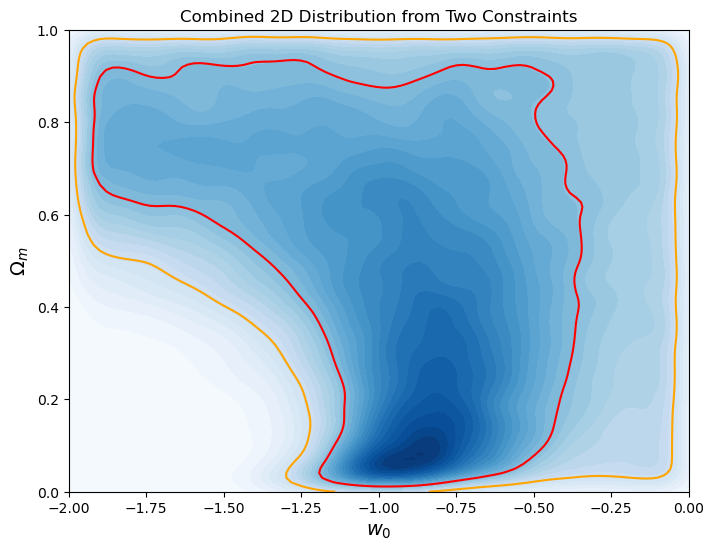

In [148]:
np.random.seed(0)  # For reproducibility

#Generate KDEs for both distributions mcmc_samples_AGEL1507 and mcmc_samples_collett
kde1_dcls1507 = gaussian_kde(mcmc_samples_AGEL1507.T)
kde2_J0946 = gaussian_kde(mcmc_samples_collett.T)
#kde3 = gaussian_kde(mcmc_samples_wcdm_planck_kde.T)

# Define a grid over which to evaluate the combined distribution
x_grid, y_grid = np.mgrid[-2.0:0:100j, 0.0:1:100j ]
positions = np.vstack([x_grid.ravel(), y_grid.ravel()])

# Combine the distributions (multiply the KDEs)
combined_density_DSPLs = kde1_dcls1507(positions) * kde2_J0946(positions)

combined_density_DSPLs = combined_density_DSPLs.reshape(x_grid.shape)

# Sort the density values to determine the confidence levels
sorted_density = np.sort(combined_density_DSPLs.ravel())[::-1] #sorted density in decensing order
cumulative_density = np.cumsum(sorted_density) / np.sum(sorted_density)

# Find density thresholds for the desired confidence levels (1, 2, and 3 sigma)
cof_levels = [
    #sorted_density[np.searchsorted(cumulative_density, 0.9973)],  # 3-sigma
    sorted_density[np.searchsorted(cumulative_density, 0.9545)],  # 2-sigma
    sorted_density[np.searchsorted(cumulative_density, 0.6827)],  # 1-sigma
]

# Calculate the total probability density
total_density = np.sum(combined_density_DSPLs)

# Calculate the CDF
cdf = np.cumsum(combined_density_DSPLs.ravel())
cdf /= cdf[-1]  # Normalize the CDF

# Find the median (50th percentile)
#this is wrong for the second element omega_m
#median_index = np.searchsorted(cdf, 0.5)
#median = positions[:, median_index] 


# Plot the combined 2D distribution
plt.figure(figsize=(8, 6))
plt.contourf(x_grid, y_grid, combined_density_DSPLs, levels=30, cmap='Blues')
contours = plt.contour(x_grid, y_grid, combined_density_DSPLs, levels=cof_levels, colors=[ 'orange', 'red']) #'yellow',
#plt.clabel(contours, inline=True, fontsize=8, fmt={level: f"{sigma}-sigma" for sigma, level in zip([3, 2, 1], levels)})
#plt.colorbar(label='Density')
#plt.axvline(median[0])
#plt.axhline(median[1])
plt.title("Combined 2D Distribution from Two Constraints")
plt.xlabel(r"$w_0$", fontsize=14)
plt.ylabel(r"$\Omega_m$", fontsize=14)
#ax.set_xlabel(r"$w_0$", fontsize=14)  # X-axis label
#ax.set_ylabel(r"$\Omega_m$", fontsize=14)  # Y-axis label

plt.show()

In [149]:
#cumulative_density is based on combined density sorted in descending order. 
#while CDF is not sorted maintains the original order
#use cumulative_density for 68% bounds

# Find the density thresholds that correspond to the 68% confidence level
threshold_density = sorted_density[np.searchsorted(cumulative_density, 0.95)] #cdf #0.6827
print(threshold_density)
#print(cof_levels)
# Flatten combined_density and positions
flattened_density = combined_density_DSPLs.ravel()  # This creates a 1D array
flattened_positions = positions.T  # Transpose to get a shape of (n, 2) where n is the number of grid points

# Create a mask for samples above the threshold
within_bounds_mask = flattened_density >= threshold_density

# Check the mask to see if it is properly constructed
print("Within Bounds Mask Shape:", within_bounds_mask.shape)  # Should be (n,)
print("Number of samples within bounds:", np.sum(within_bounds_mask))

# Extract filtered samples based on the mask
filtered_samples_DSPLs = flattened_positions[within_bounds_mask]

# Check the shape of the filtered samples
print("Filtered Samples Shape:", filtered_samples_DSPLs.shape)  # Should be (m, 2) where m is the number of filtered samples

# Separate into w_0 and Ω_m
w_0_samples = filtered_samples_DSPLs[:, 0]  # First column corresponds to w_0
Omega_m_samples = filtered_samples_DSPLs[:, 1]  # Second column corresponds to Ω_m

# Find the median (50th percentile).
#Use CDF for median calculation, becasue cumulative distribution functions (CDFs) preserve the original order of density values.
#the original order is important for calculating median that divides the distribiution into two halfs

median_index = np.searchsorted(cdf, 0.5)
median_dspl = positions[:, median_index]  # [w_0, Omega_m]

# Print the median results
print("Median cdf (w_0, Omega_m):", median_dspl)
#median_dspl_w0=median_dspl[0]
#median_dspl_Omega_m=median_dspl[1]
median_dspl_w0=np.median(w_0_samples)
median_dspl_Omega_m=np.median(Omega_m_samples)

# Calculate and print the bounds for the filtered samples
lower_bound_w0 = np.min(w_0_samples)
upper_bound_w0 = np.max(w_0_samples)

lower_bound_Omega_m = np.min(Omega_m_samples)
upper_bound_Omega_m = np.max(Omega_m_samples)
#
print("68% Confidence Bound for w_0: [{:.4f}, {:.4f}]".format(lower_bound_w0, upper_bound_w0))
print("68% Confidence Bound for Ω_m: [{:.4f}, {:.4f}]".format(lower_bound_Omega_m, upper_bound_Omega_m))

# Display the median values with uncertainties
display(Latex(f'Median values: $w = {median_dspl_w0:.3f}_{{-{median_dspl_w0 - lower_bound_w0:.3f}}}^{{+{upper_bound_w0 - median_dspl_w0:.3f}}}$'))
display(Latex(f'Median values: $\Omega_m = {median_dspl_Omega_m:.3f}_{{-{median_dspl_Omega_m - lower_bound_Omega_m:.3f}}}^{{+{upper_bound_Omega_m - median_dspl_Omega_m:.3f}}}$'))

#obtaining parameters with maximum combined probability
max_index = np.argmax(combined_density_DSPLs.ravel())  # Find index of maximum
print(max_index)
max_dens_parameters=positions[:,max_index]
print(max_dens_parameters)

0.09579408483227345
Within Bounds Mask Shape: (10000,)
Number of samples within bounds: 7573
Filtered Samples Shape: (7573, 2)
Median cdf (w_0, Omega_m): [-0.86868687  0.05050505]
68% Confidence Bound for w_0: [-1.9596, -0.0404]
68% Confidence Bound for Ω_m: [0.0000, 0.9798]


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

5608
[-0.86868687  0.08080808]


### Plotting with levels

### Combined KDE comparing two methods: multiplication and Geometric mean

In [47]:
def save_kde_distributions(Z, x, y, filename='kde_distributions.h5'):
    """Save a single KDE distribution and grid points to an HDF5 file."""
    with h5py.File(filename, 'w') as f:  # 'w' mode overwrites the file
        f.create_dataset('Z', data=Z)  # Save as 'Z'
        f.create_dataset('x', data=x)
        f.create_dataset('y', data=y)

def load_kde_distributions(filename='kde_distributions.h5'):
    """Load a single KDE distribution and grid points from an HDF5 file."""
    with h5py.File(filename, 'r') as f:
        Z = f['Z'][:]  # Load from 'Z'
        x = f['x'][:]
        y = f['y'][:]
    return Z, x, y

In [48]:
'''
def plot_kde_comparison_stats_correlation(mcmc_samples1, mcmc_samples2, grid_points=100, save_file_mult='kde_dist_MULT.h5', save_file_geom='kde_dist_GEOM.h5' ):
    """
    Plot individual and combined KDEs with improved visibility, avoiding correlation loss
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))

    # Compute bounds
    x_min = min(mcmc_samples1[:, 0].min(), mcmc_samples2[:, 0].min())
    x_max = max(mcmc_samples1[:, 0].max(), mcmc_samples2[:, 0].max())
    y_min = min(mcmc_samples1[:, 1].min(), mcmc_samples2[:, 1].min())
    y_max = max(mcmc_samples1[:, 1].max(), mcmc_samples2[:, 1].max())

    # Create evaluation grid
    x = np.linspace(x_min, x_max, grid_points)
    y = np.linspace(y_min, y_max, grid_points)
    X, Y = np.meshgrid(x, y)
    positions = np.vstack([X.ravel(), Y.ravel()])

    # Compute individual KDEs
    kde1 = stats.gaussian_kde(mcmc_samples1.T)
    kde2 = stats.gaussian_kde(mcmc_samples2.T)

    # Evaluate KDEs
    Z1 = np.reshape(kde1(positions), X.shape)
    Z2 = np.reshape(kde2(positions), X.shape)

    # Normalize individual KDEs
    Z1 /= Z1.sum()
    Z2 /= Z2.sum()

    # Method 1: Simple multiplication
    Z_mult = Z1 * Z2
    Z_mult /= Z_mult.sum()

    # Method 2: Sum of log probabilities (geometric mean)
    Z_geom = np.exp(0.5 * (np.log(Z1 + 1e-10) + np.log(Z2 + 1e-10)))
    Z_geom /= Z_geom.sum()

    # Save KDE distributions to file
    save_kde_distributions(Z_mult, x, y, filename=save_file_mult)
    save_kde_distributions(Z_geom, x, y, filename=save_file_geom)

    def compute_joint_statistics(Z):
        """Compute statistics from the full 2D distribution to preserve correlations and compute median"""
        Z_flat = Z.ravel()
        Z_flat /= Z_flat.sum()

        X_flat = X.ravel()
        Y_flat = Y.ravel()

        # Mean
        mean_x = np.sum(X_flat * Z_flat)
        mean_y = np.sum(Y_flat * Z_flat)

        # Covariance
        cov_xx = np.sum((X_flat - mean_x)**2 * Z_flat)
        cov_yy = np.sum((Y_flat - mean_y)**2 * Z_flat)
        cov_xy = np.sum((X_flat - mean_x)*(Y_flat - mean_y) * Z_flat)

        cov_matrix = np.array([[cov_xx, cov_xy], [cov_xy, cov_yy]])

        # Mode
        mode_idx = np.argmax(Z_flat)
        mode_x = X_flat[mode_idx]
        mode_y = Y_flat[mode_idx]

        # Median (via sampling from Z)
        sorted_indices = np.argsort(Z_flat)[::-1]
        cumulative_prob = np.cumsum(Z_flat[sorted_indices])
        median_idx = sorted_indices[np.searchsorted(cumulative_prob, 0.5)]
        median_x = X_flat[median_idx]
        median_y = Y_flat[median_idx]

        return {
            'mode': (mode_x, mode_y),
            'mean': (mean_x, mean_y),
            'median': (median_x, median_y),
            'covariance': cov_matrix
        }

    stats_mult = compute_joint_statistics(Z_mult)
    stats_geom = compute_joint_statistics(Z_geom)

    # Relative differences
    def relative_diff(v1, v2):
        return abs(v1 - v2) / ((abs(v1) + abs(v2)) / 2) * 100

    differences = {
        'mode_x_diff': relative_diff(stats_mult['mode'][0], stats_geom['mode'][0]),
        'mode_y_diff': relative_diff(stats_mult['mode'][1], stats_geom['mode'][1]),
        'median_x_diff': relative_diff(stats_mult['median'][0], stats_geom['median'][0]),
        'median_y_diff': relative_diff(stats_mult['median'][1], stats_geom['median'][1]),
        'mean_x_diff': relative_diff(stats_mult['mean'][0], stats_geom['mean'][0]),
        'mean_y_diff': relative_diff(stats_mult['mean'][1], stats_geom['mean'][1])
    }

    # Function to plot KDE
    def plot_kde(ax, Z, samples1=None, samples2=None, title=''):
        contf = ax.contourf(X, Y, Z, levels=20, cmap='viridis', alpha=0.7)
        ax.contour(X, Y, Z, levels=8, colors='white', linewidths=0.5, alpha=0.8)

        if samples1 is not None:
            ax.scatter(samples1[:, 0], samples1[:, 1], alpha=0.02, color='red', s=1, label='Sample 1')
        if samples2 is not None:
            ax.scatter(samples2[:, 0], samples2[:, 1], alpha=0.02, color='blue', s=1, label='Sample 2')

        ax.set_title(title)
        if samples1 is not None or samples2 is not None:
            ax.legend()
        return contf

    # Plotting
    plot_kde(axes[0, 0], Z1, samples1=mcmc_samples1, title='First Sample KDE')
    plot_kde(axes[0, 1], Z2, samples2=mcmc_samples2, title='Second Sample KDE')
    plot_kde(axes[1, 0], Z_mult, samples1=mcmc_samples1, samples2=mcmc_samples2, title='Combined KDE (Multiplication)')
    plot_kde(axes[1, 1], Z_geom, samples1=mcmc_samples1, samples2=mcmc_samples2, title='Combined KDE (Geometric Mean)')

    plt.tight_layout()
    return fig, stats_mult, stats_geom, differences
    
fig2, stats_mult2, stats_geom2, differences2 = plot_kde_comparison_stats_correlation(mcmc_samples_AGEL1507, mcmc_samples_collett, save_file_mult='kde_DSPLs_MULT1.h5', save_file_geom='kde_DSPLs_GEOM1.h5')
plt.show()
'''

'\ndef plot_kde_comparison_stats_correlation(mcmc_samples1, mcmc_samples2, grid_points=100, save_file_mult=\'kde_dist_MULT.h5\', save_file_geom=\'kde_dist_GEOM.h5\' ):\n    """\n    Plot individual and combined KDEs with improved visibility, avoiding correlation loss\n    """\n    fig, axes = plt.subplots(2, 2, figsize=(15, 15))\n\n    # Compute bounds\n    x_min = min(mcmc_samples1[:, 0].min(), mcmc_samples2[:, 0].min())\n    x_max = max(mcmc_samples1[:, 0].max(), mcmc_samples2[:, 0].max())\n    y_min = min(mcmc_samples1[:, 1].min(), mcmc_samples2[:, 1].min())\n    y_max = max(mcmc_samples1[:, 1].max(), mcmc_samples2[:, 1].max())\n\n    # Create evaluation grid\n    x = np.linspace(x_min, x_max, grid_points)\n    y = np.linspace(y_min, y_max, grid_points)\n    X, Y = np.meshgrid(x, y)\n    positions = np.vstack([X.ravel(), Y.ravel()])\n\n    # Compute individual KDEs\n    kde1 = stats.gaussian_kde(mcmc_samples1.T)\n    kde2 = stats.gaussian_kde(mcmc_samples2.T)\n\n    # Evaluate KDEs\

In [49]:
def plot_kde_comparison_stats_sample(mcmc_samples1, mcmc_samples2, grid_points=100, save_file_mult='kde_dist_MULT.h5', save_file_geom='kde_dist_GEOM.h5', n_samples=10000):
    """
    Plot individual and combined KDEs with improved visibility and return samples from combined KDE.
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))

    # Compute bounds
    x_min = min(mcmc_samples1[:, 0].min(), mcmc_samples2[:, 0].min())
    x_max = max(mcmc_samples1[:, 0].max(), mcmc_samples2[:, 0].max())
    y_min = min(mcmc_samples1[:, 1].min(), mcmc_samples2[:, 1].min())
    y_max = max(mcmc_samples1[:, 1].max(), mcmc_samples2[:, 1].max())

    # Create evaluation grid
    x = np.linspace(x_min, x_max, grid_points)
    y = np.linspace(y_min, y_max, grid_points)
    X, Y = np.meshgrid(x, y)
    positions = np.vstack([X.ravel(), Y.ravel()])

    # Compute individual KDEs
    kde1 = stats.gaussian_kde(mcmc_samples1.T)
    kde2 = stats.gaussian_kde(mcmc_samples2.T)

    # Evaluate KDEs
    Z1 = np.reshape(kde1(positions), X.shape)
    Z2 = np.reshape(kde2(positions), X.shape)

    # Normalize individual KDEs
    Z1 /= Z1.sum()
    Z2 /= Z2.sum()

    # Method 1: Simple multiplication
    Z_mult = Z1 * Z2
    Z_mult /= Z_mult.sum()

    # Method 2: Sum of log probabilities (geometric mean)
    Z_geom = np.exp(0.5 * (np.log(Z1 + 1e-10) + np.log(Z2 + 1e-10)))
    Z_geom /= Z_geom.sum()

    # Save KDE distributions to file
    save_kde_distributions(Z_mult, x, y, filename=save_file_mult)
    save_kde_distributions(Z_geom, x, y, filename=save_file_geom)

    def compute_statistics(Z, x, y):
        """Compute various statistics for a given 2D distribution"""
        mode_idx = np.unravel_index(np.argmax(Z), Z.shape)
        mode_x = X[mode_idx]
        mode_y = Y[mode_idx]

        dx = x[1] - x[0]
        dy = y[1] - y[0]
        marginal_x = np.sum(Z, axis=0) * dy
        marginal_y = np.sum(Z, axis=1) * dx

        marginal_x /= marginal_x.sum()
        marginal_y /= marginal_y.sum()

        cumsum_x = np.cumsum(marginal_x)
        cumsum_y = np.cumsum(marginal_y)

        median_x = x[np.argmin(np.abs(cumsum_x - 0.5))]
        median_y = y[np.argmin(np.abs(cumsum_y - 0.5))]

        lower_x = x[np.argmin(np.abs(cumsum_x - 0.16))]
        upper_x = x[np.argmin(np.abs(cumsum_x - 0.84))]
        lower_y = y[np.argmin(np.abs(cumsum_y - 0.16))]
        upper_y = y[np.argmin(np.abs(cumsum_y - 0.84))]

        mean_x = np.sum(x * marginal_x)
        mean_y = np.sum(y * marginal_y)

        std_x = np.sqrt(np.sum((x - mean_x)**2 * marginal_x))
        std_y = np.sqrt(np.sum((y - mean_y)**2 * marginal_y))

        return {
            'mode': (mode_x, mode_y),
            'median': (median_x, median_y),
            'mean': (mean_x, mean_y),
            'std': (std_x, std_y),
            'confidence_intervals': {
                'x': (lower_x, upper_x),
                'y': (lower_y, upper_y)
            }
        }

    # Compute statistics for each method
    stats_mult = compute_statistics(Z_mult, x, y)
    stats_geom = compute_statistics(Z_geom, x, y)

    # Calculate relative differences
    def relative_diff(v1, v2):
        return abs(v1 - v2) / ((abs(v1) + abs(v2)) / 2) * 100

    differences = {
        'mode_x_diff': relative_diff(stats_mult['mode'][0], stats_geom['mode'][0]),
        'mode_y_diff': relative_diff(stats_mult['mode'][1], stats_geom['mode'][1]),
        'median_x_diff': relative_diff(stats_mult['median'][0], stats_geom['median'][0]),
        'median_y_diff': relative_diff(stats_mult['median'][1], stats_geom['median'][1]),
        'mean_x_diff': relative_diff(stats_mult['mean'][0], stats_geom['mean'][0]),
        'mean_y_diff': relative_diff(stats_mult['mean'][1], stats_geom['mean'][1])
    }

    # Sample from combined KDE (Z_mult)
    Z_flat = Z_mult.ravel()
    Z_flat /= Z_flat.sum()
    indices = np.random.choice(len(Z_flat), size=n_samples, p=Z_flat)
    w_samples = X.ravel()[indices]
    omega_m_samples = Y.ravel()[indices]
    combined_samples = np.vstack([w_samples, omega_m_samples]).T

    # Function to plot KDE with improved visibility
    def plot_kde(ax, Z, samples1=None, samples2=None, title=''):
        contf = ax.contourf(X, Y, Z, levels=20, cmap='viridis', alpha=0.7)
        cont = ax.contour(X, Y, Z, levels=8, colors='white', linewidths=0.5, alpha=0.8)

        if samples1 is not None:
            ax.scatter(samples1[:, 0], samples1[:, 1], alpha=0.02, color='red', s=1, label='Sample 1')
        if samples2 is not None:
            ax.scatter(samples2[:, 0], samples2[:, 1], alpha=0.02, color='blue', s=1, label='Sample 2')

        ax.set_title(title)
        if samples1 is not None or samples2 is not None:
            ax.legend()
        return contf

    # Plot each panel
    plot_kde(axes[0, 0], Z1, samples1=mcmc_samples1, title='First Sample KDE')
    plot_kde(axes[0, 1], Z2, samples2=mcmc_samples2, title='Second Sample KDE')
    plot_kde(axes[1, 0], Z_mult, samples1=mcmc_samples1, samples2=mcmc_samples2, title='Combined KDE (Multiplication)')
    plot_kde(axes[1, 1], Z_geom, samples1=mcmc_samples1, samples2=mcmc_samples2, title='Combined KDE (Geometric Mean)')

    plt.tight_layout()
    return fig, stats_mult, stats_geom, differences, combined_samples


In [50]:
def plot_kde_comparison_stats_3sample(mcmc_samples1, mcmc_samples2, mcmc_samples3, grid_points=100,save_file_mult='kde3_dist_MULT.h5', save_file_geom='kde3_dist_GEOM.h5', n_samples=10000):
    """
    Plot individual and combined KDEs for three MCMC samples with improved visibility.
    """
    fig, axes = plt.subplots(3, 2, figsize=(18, 20))
    
    # Compute bounds
    x_min = min(mcmc_samples1[:, 0].min(), mcmc_samples2[:, 0].min(), mcmc_samples3[:, 0].min())
    x_max = max(mcmc_samples1[:, 0].max(), mcmc_samples2[:, 0].max(), mcmc_samples3[:, 0].max())
    y_min = min(mcmc_samples1[:, 1].min(), mcmc_samples2[:, 1].min(), mcmc_samples3[:, 1].min())
    y_max = max(mcmc_samples1[:, 1].max(), mcmc_samples2[:, 1].max(), mcmc_samples3[:, 1].max())
    
    # Create evaluation grid
    x = np.linspace(x_min, x_max, grid_points)
    y = np.linspace(y_min, y_max, grid_points)
    X, Y = np.meshgrid(x, y)
    positions = np.vstack([X.ravel(), Y.ravel()])
    
    # Compute individual KDEs
    kde1 = stats.gaussian_kde(mcmc_samples1.T)
    kde2 = stats.gaussian_kde(mcmc_samples2.T)
    kde3 = stats.gaussian_kde(mcmc_samples3.T)
    
    # Evaluate KDEs
    Z1 = np.reshape(kde1(positions), X.shape)
    Z2 = np.reshape(kde2(positions), X.shape)
    Z3 = np.reshape(kde3(positions), X.shape)
    
    # Normalize individual KDEs
    Z1 /= Z1.sum()
    Z2 /= Z2.sum()
    Z3 /= Z3.sum()
    
    # Method 1: Simple multiplication
    Z_mult = Z1 * Z2 * Z3
    Z_mult /= Z_mult.sum()
    
    # Method 2: Sum of log probabilities (geometric mean)
    Z_geom = np.exp((np.log(Z1 + 1e-10) + np.log(Z2 + 1e-10) + np.log(Z3 + 1e-10)) / 3)
    Z_geom /= Z_geom.sum()
    
    # Save KDE distributions to file
    save_kde_distributions(Z_mult, x, y, filename=save_file_mult)
    save_kde_distributions(Z_geom, x, y, filename=save_file_geom)
    
    # Define function for statistics computation (unchanged)
    def compute_statistics(Z, x, y):
        """Compute various statistics for a given 2D distribution."""
        mode_idx = np.unravel_index(np.argmax(Z), Z.shape)
        mode_x, mode_y = X[mode_idx], Y[mode_idx]
        dx, dy = x[1] - x[0], y[1] - y[0]
        marginal_x = np.sum(Z, axis=0) * dy
        marginal_y = np.sum(Z, axis=1) * dx
        marginal_x /= marginal_x.sum()
        marginal_y /= marginal_y.sum()
        cumsum_x = np.cumsum(marginal_x)
        cumsum_y = np.cumsum(marginal_y)
        median_x = x[np.argmin(np.abs(cumsum_x - 0.5))]
        median_y = y[np.argmin(np.abs(cumsum_y - 0.5))]
        lower_x = x[np.argmin(np.abs(cumsum_x - 0.16))]
        upper_x = x[np.argmin(np.abs(cumsum_x - 0.84))]
        lower_y = y[np.argmin(np.abs(cumsum_y - 0.16))]
        upper_y = y[np.argmin(np.abs(cumsum_y - 0.84))]
        mean_x = np.sum(x * marginal_x)
        mean_y = np.sum(y * marginal_y)
        std_x = np.sqrt(np.sum((x - mean_x)**2 * marginal_x))
        std_y = np.sqrt(np.sum((y - mean_y)**2 * marginal_y))
        return {
            'mode': (mode_x, mode_y),
            'median': (median_x, median_y),
            'mean': (mean_x, mean_y),
            'std': (std_x, std_y),
            'confidence_intervals': {'x': (lower_x, upper_x), 'y': (lower_y, upper_y)}
        }
    
    # Compute statistics
    stats_mult = compute_statistics(Z_mult, x, y)
    stats_geom = compute_statistics(Z_geom, x, y)
    
    # Sample from combined KDE (Z_mult)
    Z_flat = Z_mult.ravel()
    Z_flat /= Z_flat.sum()
    indices = np.random.choice(len(Z_flat), size=n_samples, p=Z_flat)
    w_samples = X.ravel()[indices]
    omega_m_samples = Y.ravel()[indices]
    combined_samples = np.vstack([w_samples, omega_m_samples]).T
    
    # Plotting function (unchanged)
    def plot_kde(ax, Z, samples1=None, samples2=None, samples3=None, title=''):
        contf = ax.contourf(X, Y, Z, levels=20, cmap='viridis', alpha=0.7)
        cont = ax.contour(X, Y, Z, levels=8, colors='white', linewidths=0.5, alpha=0.8)
        if samples1 is not None:
            ax.scatter(samples1[:, 0], samples1[:, 1], alpha=0.02, color='red', s=1, label='Sample 1')
        if samples2 is not None:
            ax.scatter(samples2[:, 0], samples2[:, 1], alpha=0.02, color='blue', s=1, label='Sample 2')
        if samples3 is not None:
            ax.scatter(samples3[:, 0], samples3[:, 1], alpha=0.02, color='green', s=1, label='Sample 3')
        ax.set_title(title)
        if samples1 is not None or samples2 is not None or samples3 is not None:
            ax.legend()
        return contf   
    
    # Plot each panel
    plot_kde(axes[0, 0], Z1, samples1=mcmc_samples1, title='First Sample KDE')
    plot_kde(axes[0, 1], Z2, samples2=mcmc_samples2, title='Second Sample KDE')
    plot_kde(axes[1, 0], Z3, samples3=mcmc_samples3, title='Third Sample KDE')
    plot_kde(axes[1, 1], Z_mult, samples1=mcmc_samples1, samples2=mcmc_samples2, samples3=mcmc_samples3, title='Combined KDE (Multiplication)')
    plot_kde(axes[2, 0], Z_geom, samples1=mcmc_samples1, samples2=mcmc_samples2, samples3=mcmc_samples3, title='Combined KDE (Geometric Mean)')
    
    for ax, data in zip(axes.flat, [Z1, Z2, Z3, Z_mult, Z_geom]):
        plt.colorbar(ax.collections[0], ax=ax)
        ax.grid(True, linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    return fig, stats_mult, stats_geom, combined_samples


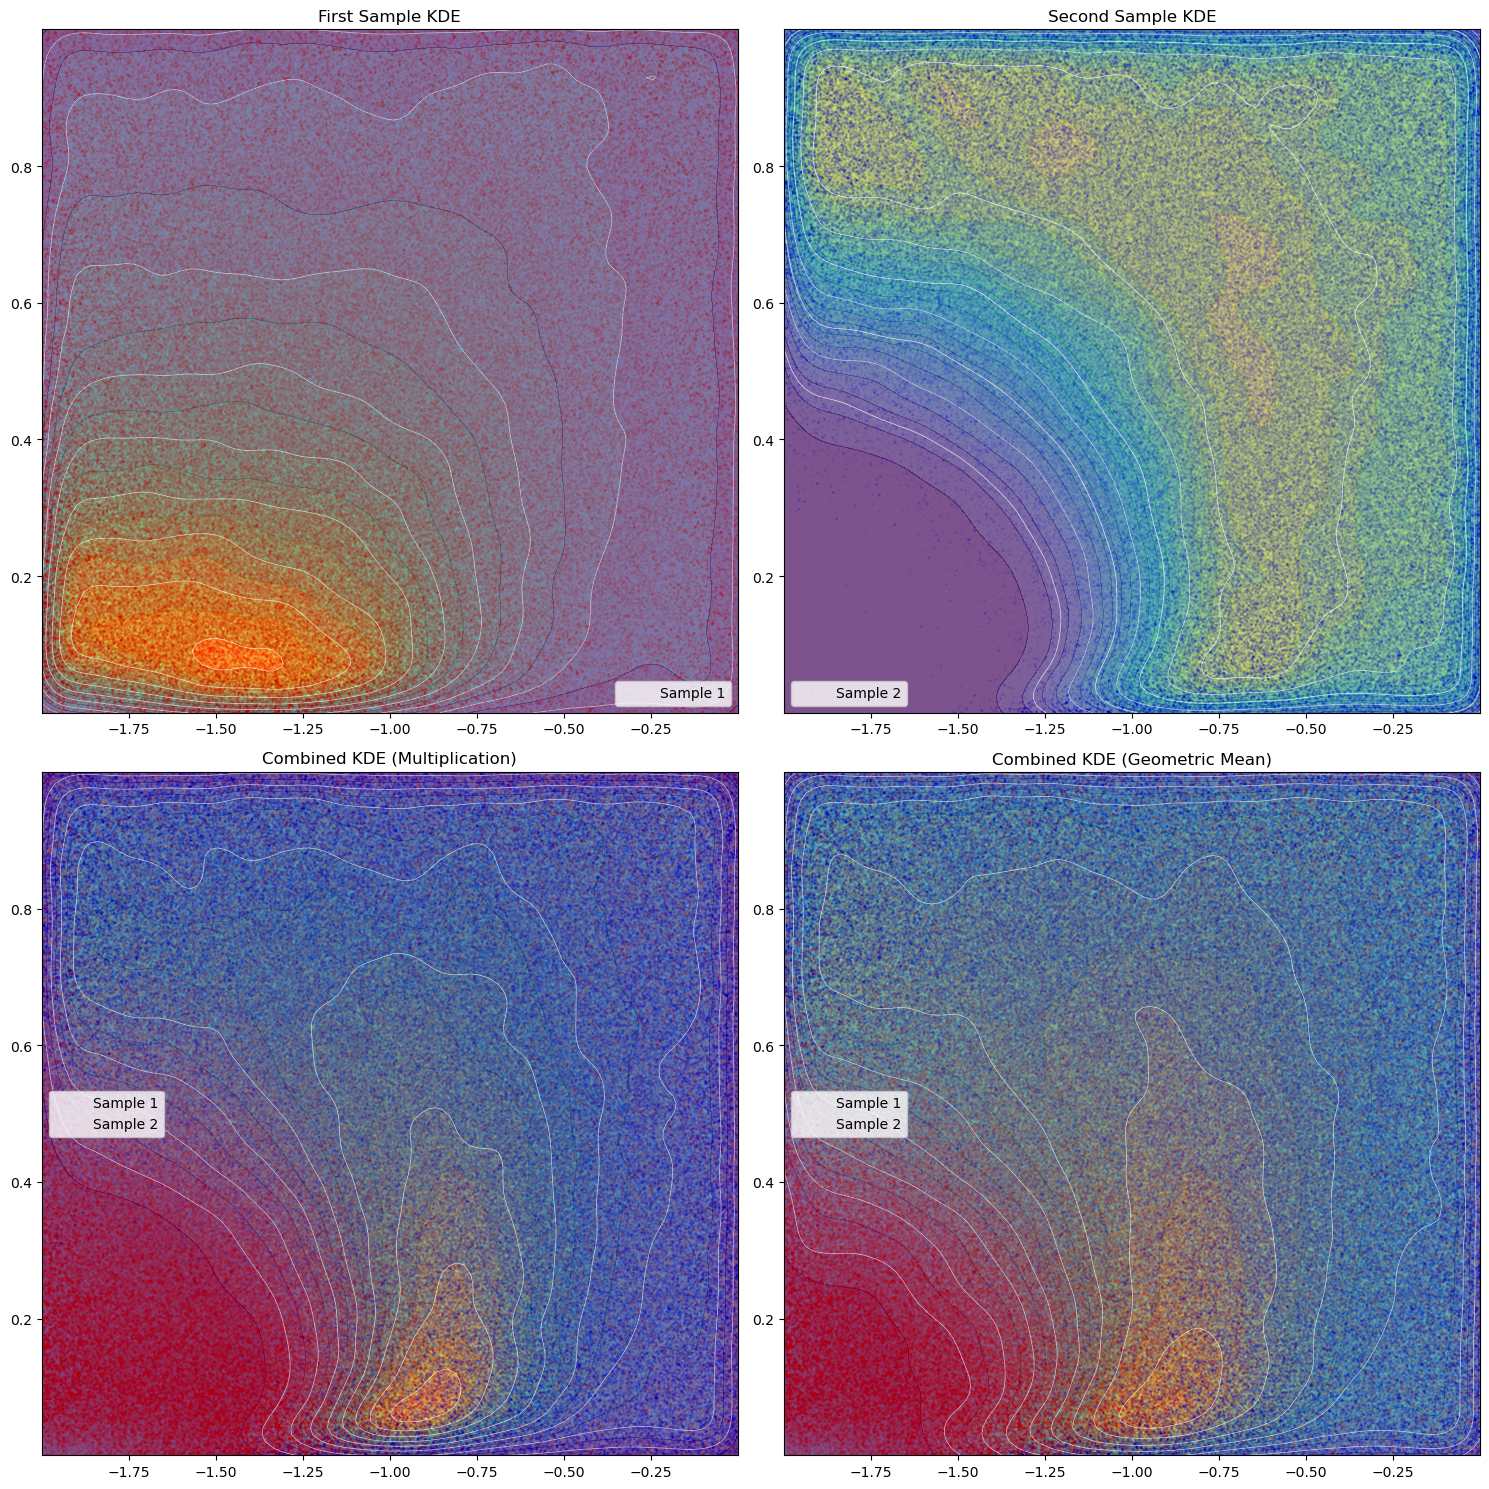

In [51]:
# Create the improved plots mcmc_samples_AGEL1507 and mcmc_samples_collett
fig3, stats_mult3, stats_geom3, differences3, combined_DSPL_samples3 = plot_kde_comparison_stats_sample(mcmc_samples_AGEL1507, mcmc_samples_collett, grid_points=100, save_file_mult='kde_DSPLs_MULT1.h5', save_file_geom='kde_DSPLs_GEOM1.h5')
plt.show()

In [52]:
print("Multiplication Method:")
print(f"Mode: ({stats_mult3['mode'][0]:.4f}, {stats_mult3['mode'][1]:.4f})")
print(f"Median: ({stats_mult3['median'][0]:.4f}, {stats_mult3['median'][1]:.4f})")
print(f"Mean: ({stats_mult3['mean'][0]:.4f}, {stats_mult3['mean'][1]:.4f})")
print(f"Std Dev: ({stats_mult3['std'][0]:.4f}, {stats_mult3['std'][1]:.4f})")
print(f"68% CI X: [{stats_mult3['confidence_intervals']['x'][0]:.4f}, {stats_mult3['confidence_intervals']['x'][1]:.4f}]")
print(f"68% CI Y: [{stats_mult3['confidence_intervals']['y'][0]:.4f}, {stats_mult3['confidence_intervals']['y'][1]:.4f}]")

print("\nGeometric Mean Method:")
print(f"Mode: ({stats_geom3['mode'][0]:.4f}, {stats_geom3['mode'][1]:.4f})")
print(f"Median: ({stats_geom3['median'][0]:.4f}, {stats_geom3['median'][1]:.4f})")
print(f"Mean: ({stats_geom3['mean'][0]:.4f}, {stats_geom3['mean'][1]:.4f})")
print(f"Std Dev: ({stats_geom3['std'][0]:.4f}, {stats_geom3['std'][1]:.4f})")
print(f"68% CI X: [{stats_geom3['confidence_intervals']['x'][0]:.4f}, {stats_geom3['confidence_intervals']['x'][1]:.4f}]")
print(f"68% CI Y: [{stats_geom3['confidence_intervals']['y'][0]:.4f}, {stats_geom3['confidence_intervals']['y'][1]:.4f}]")

print("\nRelative Differences (%):")
for key, value in differences3.items():
    print(f"{key}: {value:.4f}%")
    
    
# Extract stats for convenience
med_x_DSPL, med_y_DSPL = stats_mult3['median']
low_x_DSPL, high_x_DSPL = stats_mult3['confidence_intervals']['x']
low_y_DSPL, high_y_DSPL = stats_mult3['confidence_intervals']['y']

# Calculate uncertainties
minus_x_DSPL = med_x_DSPL - low_x_DSPL
plus_x_DSPL = high_x_DSPL - med_x_DSPL
minus_y_DSPL = med_y_DSPL - low_y_DSPL
plus_y_DSPL = high_y_DSPL - med_y_DSPL

# Display nicely formatted LaTeX
display(Latex(rf'Median values (Multiplication): $w = {med_x_DSPL:.3f}_{{-{minus_x_DSPL:.3f}}}^{{+{plus_x_DSPL:.3f}}}$'))
display(Latex(rf'Median values (Multiplication): $\Omega_m = {med_y_DSPL:.3f}_{{-{minus_y_DSPL:.3f}}}^{{+{plus_y_DSPL:.3f}}}$'))


Multiplication Method:
Mode: (-0.8687, 0.0808)
Median: (-0.8889, 0.5455)
Mean: (-0.9103, 0.5258)
Std Dev: (0.4796, 0.2695)
68% CI X: [-1.4545, -0.4040]
68% CI Y: [0.2020, 0.8182]

Geometric Mean Method:
Mode: (-0.8687, 0.0808)
Median: (-0.9091, 0.5455)
Mean: (-0.9200, 0.5309)
Std Dev: (0.5184, 0.2753)
68% CI X: [-1.5151, -0.3434]
68% CI Y: [0.2020, 0.8384]

Relative Differences (%):
mode_x_diff: 0.0000%
mode_y_diff: 0.0000%
median_x_diff: 2.2472%
median_y_diff: 0.0000%
mean_x_diff: 1.0635%
mean_y_diff: 0.9647%


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Plotting DSPL combined constraints

Removed no burn in
Removed no burn in
Removed no burn in


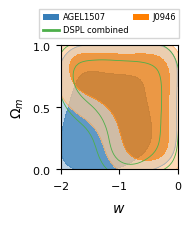

In [53]:
gdsamples1 = MCSamples(samples=mcmc_samples_AGEL1507, names=param_names, labels=param_labels)
gdsamples1.updateSettings({'fine_bins_2D': 80, 'smooth_scale_2D': 0.5})  # Higher bin count & smoothing

gdsamples2 = MCSamples(samples=mcmc_samples_collett, names=param_names, labels=param_labels)
gdsamples2.updateSettings({'fine_bins_2D': 80, 'smooth_scale_2D': 0.5})  # Higher bin count & smoothing


gdsamples12 = MCSamples(samples=combined_DSPL_samples3, names=param_names, labels=param_labels) # filtered_samples_DSPLs combined_DSPL_samples3
gdsamples12.updateSettings({'fine_bins_2D': 80, 'smooth_scale_2D': 0.5})  # Higher bin count & smoothing



#df_DSPLs_wcdm = pd.DataFrame(filtered_samples_DSPLs, columns=[r"$w$", r"$\Omega_m$"])


g = plots.get_subplot_plotter()
fig = plt.figure(figsize=(15, 15))

g.plot_2d([gdsamples1,gdsamples2, gdsamples12], param1='w', param2='omega_m', 
          filled=[True,True,False], 
          fine_bins=80,  # Higher bin count
          colors=['#377eb8','#ff7f00', '#4daf4a'], 
          alphas=[0.8, 0.7, 1], 
          #smooth_scale_2D=0.5,  # Apply KDE smoothing
          linewidths=[1,1,2],
          linestyles=['solid', 'solid', 'dashed']
         )

range_limits = {'w': [-2.0, 0.0], 'omega_m': [0.0, 1.0]}  # Adjust ranges as needed
g.set_axes(param_limits=range_limits)

ax = plt.gca()  # Get the current axes

# Manually set the axes limits if needed
plt.xlim(range_limits['w'])
plt.ylim(range_limits['omega_m'])

#contours = plt.contour(x_grid, y_grid, combined_density_DSPLs, levels=cof_levels, colors=[ '#4daf4a', '#4daf4a'], linewidths=[1, 2]) #'yellow',

# Set axes labels
ax.set_xlabel(r"$w$", fontsize=10)  # X-axis label
ax.set_ylabel(r"$\Omega_m$", fontsize=10)  # Y-axis label

# Add custom legend
legend_elements = [
    Patch(facecolor='#377eb8', label='AGEL1507'),
    Line2D([0], [0], color='#4daf4a', lw=2, label='DSPL combined'),
    Patch(facecolor='#ff7f00', label='J0946'),
]

# Add the legend to the plot
ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1.32), fancybox=False, shadow=False,
          ncol=2, fontsize=6, handletextpad=0.4, columnspacing=0.5)

plt.savefig(f'/Users/nandinisahu/Library/CloudStorage/OneDrive-UNSW/AGEL/Paper_DSPL/{job_name_out}_wLCDM_DSPL_combined_new_method.pdf', dpi=1200, bbox_inches='tight')

plt.close(fig)


### plotting CMB with DSPL combined constraints

### comining DSPLs and CMB

In [55]:
mcmc_samples_wcdm_Planck_kde = swapped_planck_slice

IOStream.flush timed out


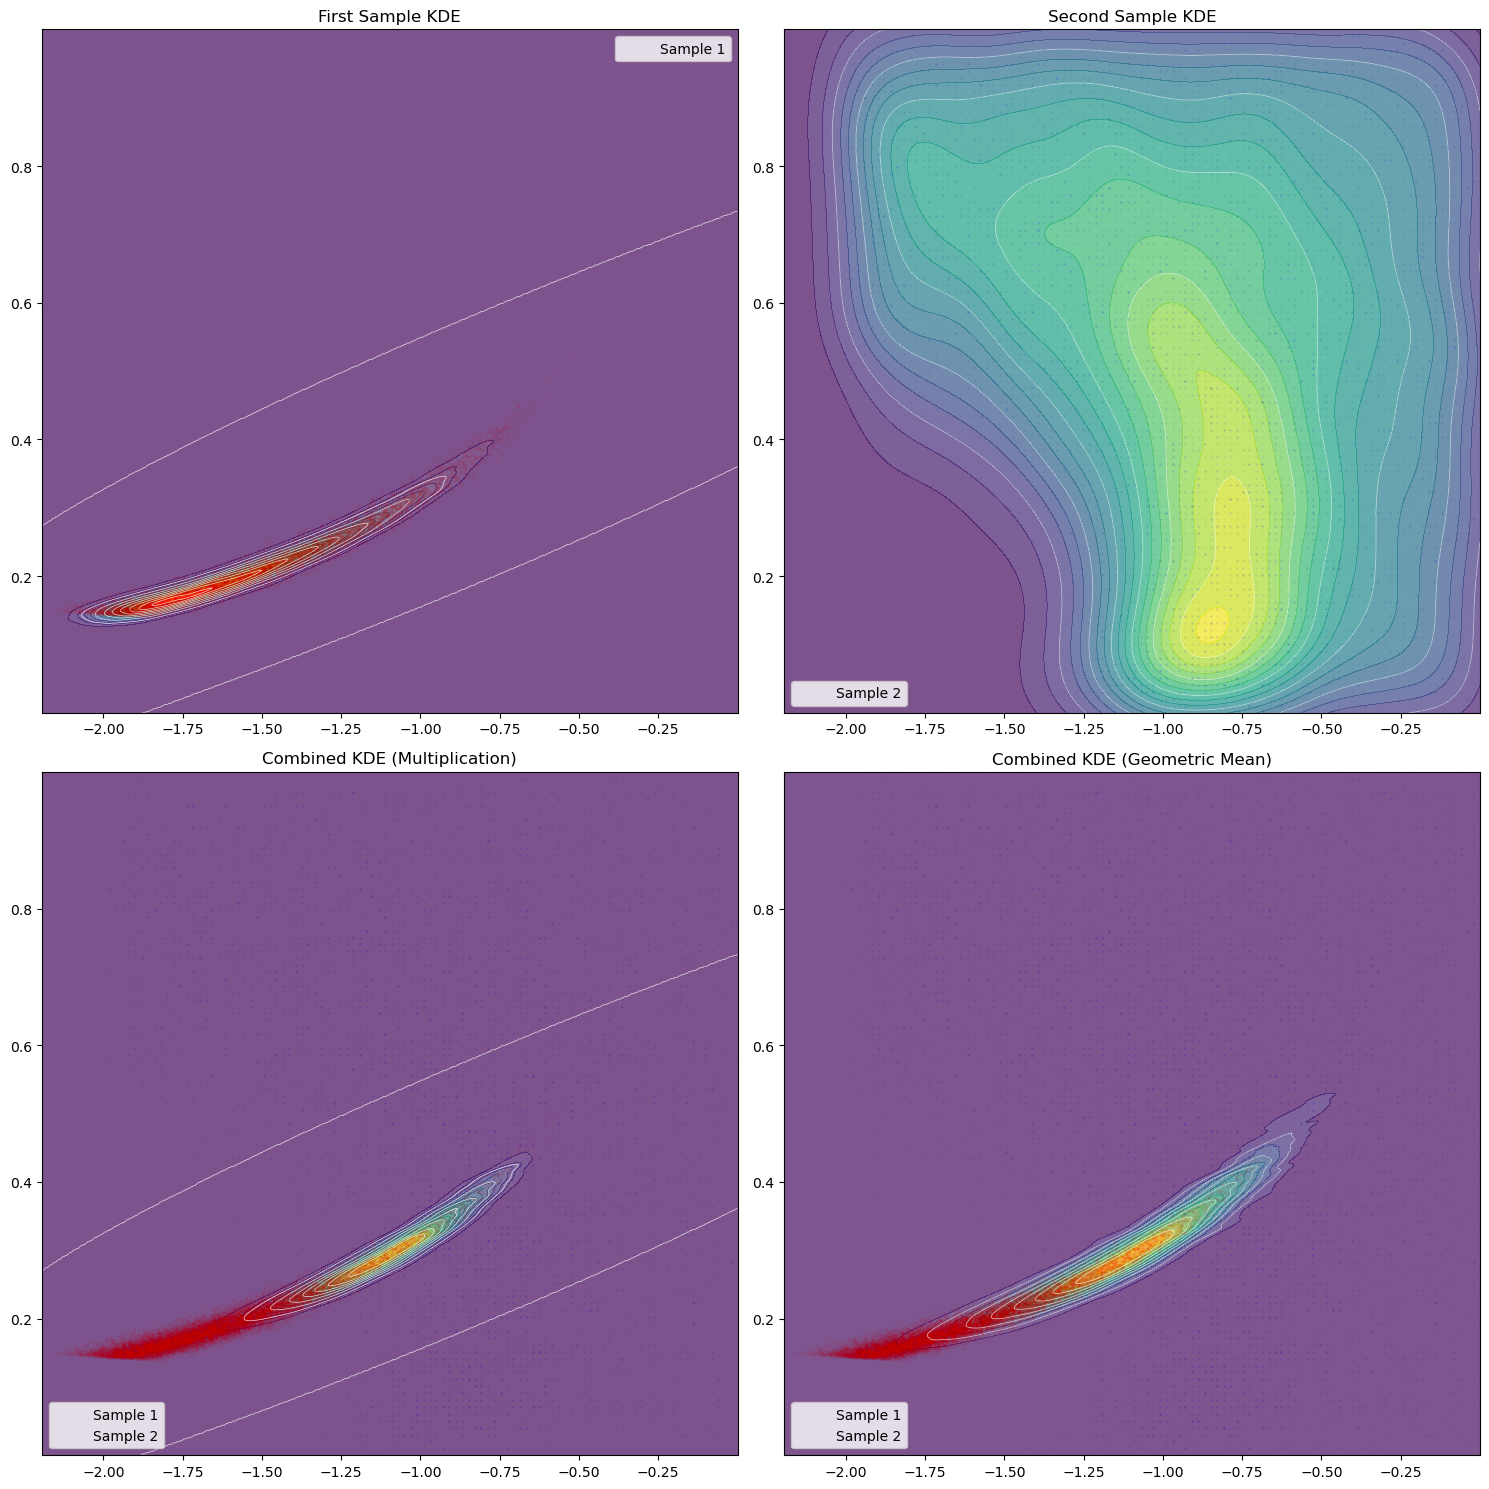

In [56]:
# Create the improved plots mcmc_samples_AGEL1507 and mcmc_samples_collett
fig4, stats_mult4, stats_geom4, differences4, combined_DSPL_CMB_samples = plot_kde_comparison_stats_sample(mcmc_samples_wcdm_Planck_kde, combined_DSPL_samples3, grid_points=500, save_file_mult='kde_DSPL_CMB_MULT.h5', save_file_geom='kde_DSPL_CMB_GEOM1.h5')
plt.show()

In [57]:
print("Multiplication Method:")
print(f"Mode: ({stats_mult4['mode'][0]:.4f}, {stats_mult4['mode'][1]:.4f})")
print(f"Median: ({stats_mult4['median'][0]:.4f}, {stats_mult4['median'][1]:.4f})")
print(f"Mean: ({stats_mult4['mean'][0]:.4f}, {stats_mult4['mean'][1]:.4f})")
print(f"Std Dev: ({stats_mult4['std'][0]:.4f}, {stats_mult4['std'][1]:.4f})")
print(f"68% CI X: [{stats_mult4['confidence_intervals']['x'][0]:.4f}, {stats_mult4['confidence_intervals']['x'][1]:.4f}]")
print(f"68% CI Y: [{stats_mult4['confidence_intervals']['y'][0]:.4f}, {stats_mult4['confidence_intervals']['y'][1]:.4f}]")

print("\nGeometric Mean Method:")
print(f"Mode: ({stats_geom4['mode'][0]:.4f}, {stats_geom4['mode'][1]:.4f})")
print(f"Median: ({stats_geom4['median'][0]:.4f}, {stats_geom4['median'][1]:.4f})")
print(f"Mean: ({stats_geom4['mean'][0]:.4f}, {stats_geom4['mean'][1]:.4f})")
print(f"Std Dev: ({stats_geom4['std'][0]:.4f}, {stats_geom4['std'][1]:.4f})")
print(f"68% CI X: [{stats_geom4['confidence_intervals']['x'][0]:.4f}, {stats_geom4['confidence_intervals']['x'][1]:.4f}]")
print(f"68% CI Y: [{stats_geom4['confidence_intervals']['y'][0]:.4f}, {stats_geom4['confidence_intervals']['y'][1]:.4f}]")

print("\nRelative Differences (%):")
for key, value in differences4.items():
    print(f"{key}: {value:.4f}%")
    
# Extract stats for convenience
med_x_DSPL_CMB, med_y_DSPL_CMB = stats_mult4['median']
low_x_DSPL_CMB, high_x_DSPL_CMB = stats_mult4['confidence_intervals']['x']
low_y_DSPL_CMB, high_y_DSPL_CMB = stats_mult4['confidence_intervals']['y']

# Calculate uncertainties
minus_x_DSPL_CMB = med_x_DSPL_CMB - low_x_DSPL_CMB
plus_x_DSPL_CMB = high_x_DSPL_CMB - med_x_DSPL_CMB
minus_y_DSPL_CMB = med_y_DSPL_CMB - low_y_DSPL_CMB
plus_y_DSPL_CMB = high_y_DSPL_CMB - med_y_DSPL_CMB

# Display nicely formatted LaTeX
display(Latex(rf'Median values (Multiplication): $w = {med_x_DSPL_CMB:.3f}_{{-{minus_x_DSPL_CMB:.3f}}}^{{+{plus_x_DSPL_CMB:.3f}}}$'))
display(Latex(rf'Median values (Multiplication): $\Omega_m = {med_y_DSPL_CMB:.3f}_{{-{minus_y_DSPL_CMB:.3f}}}^{{+{plus_y_DSPL_CMB:.3f}}}$'))


Multiplication Method:
Mode: (-1.0510, 0.3066)
Median: (-1.0993, 0.2926)
Mean: (-1.1044, 0.2983)
Std Dev: (0.2069, 0.0551)
68% CI X: [-1.3148, -0.8971]
68% CI Y: [0.2425, 0.3527]

Geometric Mean Method:
Mode: (-1.0510, 0.3066)
Median: (-1.0862, 0.2986)
Mean: (-1.0958, 0.3136)
Std Dev: (0.2997, 0.1029)
68% CI X: [-1.3984, -0.8047]
68% CI Y: [0.2265, 0.3888]

Relative Differences (%):
mode_x_diff: 0.0000%
mode_y_diff: 0.0000%
median_x_diff: 1.2072%
median_y_diff: 2.0339%
mean_x_diff: 0.7804%
mean_y_diff: 4.9987%


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### DSPLs+CMB plot

Removed no burn in
Removed no burn in
Removed no burn in


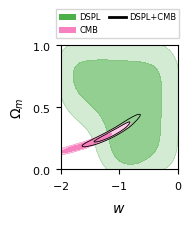

In [58]:
#combined_DSPL_samples3, filtered_samples_DSPLs
gdsamples12 = MCSamples(samples=combined_DSPL_samples3, names=param_names, labels=param_labels)
gdsamples12.updateSettings({'fine_bins_2D': 80, 'smooth_scale_2D': 0.5})  # Higher bin count & smoothing

Planck_wcdm = MCSamples(samples=swapped_planck_slice[:], names=param_names, labels=param_labels)
Planck_wcdm.updateSettings({'fine_bins_2D': 80, 'smooth_scale_2D': 0.5})  # Higher bin count & smoothing

#combined_DSPL_CMB_samples filtered_samples_DSPLs_Planck_95
DSPLs_Planck_wcdm = MCSamples(samples=combined_DSPL_CMB_samples, names=param_names, labels=param_labels)
DSPLs_Planck_wcdm.updateSettings({'fine_bins_2D': 80, 'smooth_scale_2D': 0.5})  # Higher bin count & smoothing

#df_DSPLs_wcdm = pd.DataFrame(filtered_samples_DSPLs, columns=[r"$w$", r"$\Omega_m$"])


g = plots.get_subplot_plotter()
fig = plt.figure(figsize=(15, 15))

g.plot_2d([gdsamples12, Planck_wcdm, DSPLs_Planck_wcdm], param1='w', param2='omega_m', 
          filled=[True,True,False], 
          fine_bins=80,  # Higher bin count
          colors=[CB_color_cycle['green'],CB_color_cycle['pink'],'black'], 
          alphas=[0.6, 1, 1], 
          #smooth_scale_2D=0.5,  # Apply KDE smoothing
          linewidths=[1,1,2],
          #contour_args={'linewidths': 4} 
         )

range_limits = {'w': [-2.0, 0.0], 'omega_m': [0.0, 1.0]}  # Adjust ranges as needed
g.set_axes(param_limits=range_limits)

ax = plt.gca()  # Get the current axes

# Manually set the axes limits if needed
plt.xlim(range_limits['w'])
plt.ylim(range_limits['omega_m'])


#contours = plt.contour(x_grid, y_grid, combined_density_DSPLs, levels=cof_levels, colors=[ '#4daf4a', '#4daf4a'], linewidths=[1, 2]) #'yellow',


# Set axes labels
ax.set_xlabel(r"$w$", fontsize=10)  # X-axis label
ax.set_ylabel(r"$\Omega_m$", fontsize=10)  # Y-axis label

# Add custom legend
legend_elements = [
    Patch(facecolor=CB_color_cycle['green'], label='DSPL'),
    Patch(facecolor=CB_color_cycle['pink'], label='CMB'),
    Line2D([0], [0], color='black', lw=2, label='DSPL+CMB'),
    #Patch(facecolor='black', label='DSPLxCMB'),
]

# Add the legend to the plot
ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1.32), fancybox=False, shadow=False,
          ncol=2, fontsize=6, handletextpad=0.4, columnspacing=1)


plt.savefig(f'/Users/nandinisahu/Library/CloudStorage/OneDrive-UNSW/AGEL/Paper_DSPL/{job_name_out}_wCDM_DSPL_CMB_combined_new_method.pdf', dpi=1200, bbox_inches='tight')

plt.close(fig)


## Combining CMB, SNe, and BAO

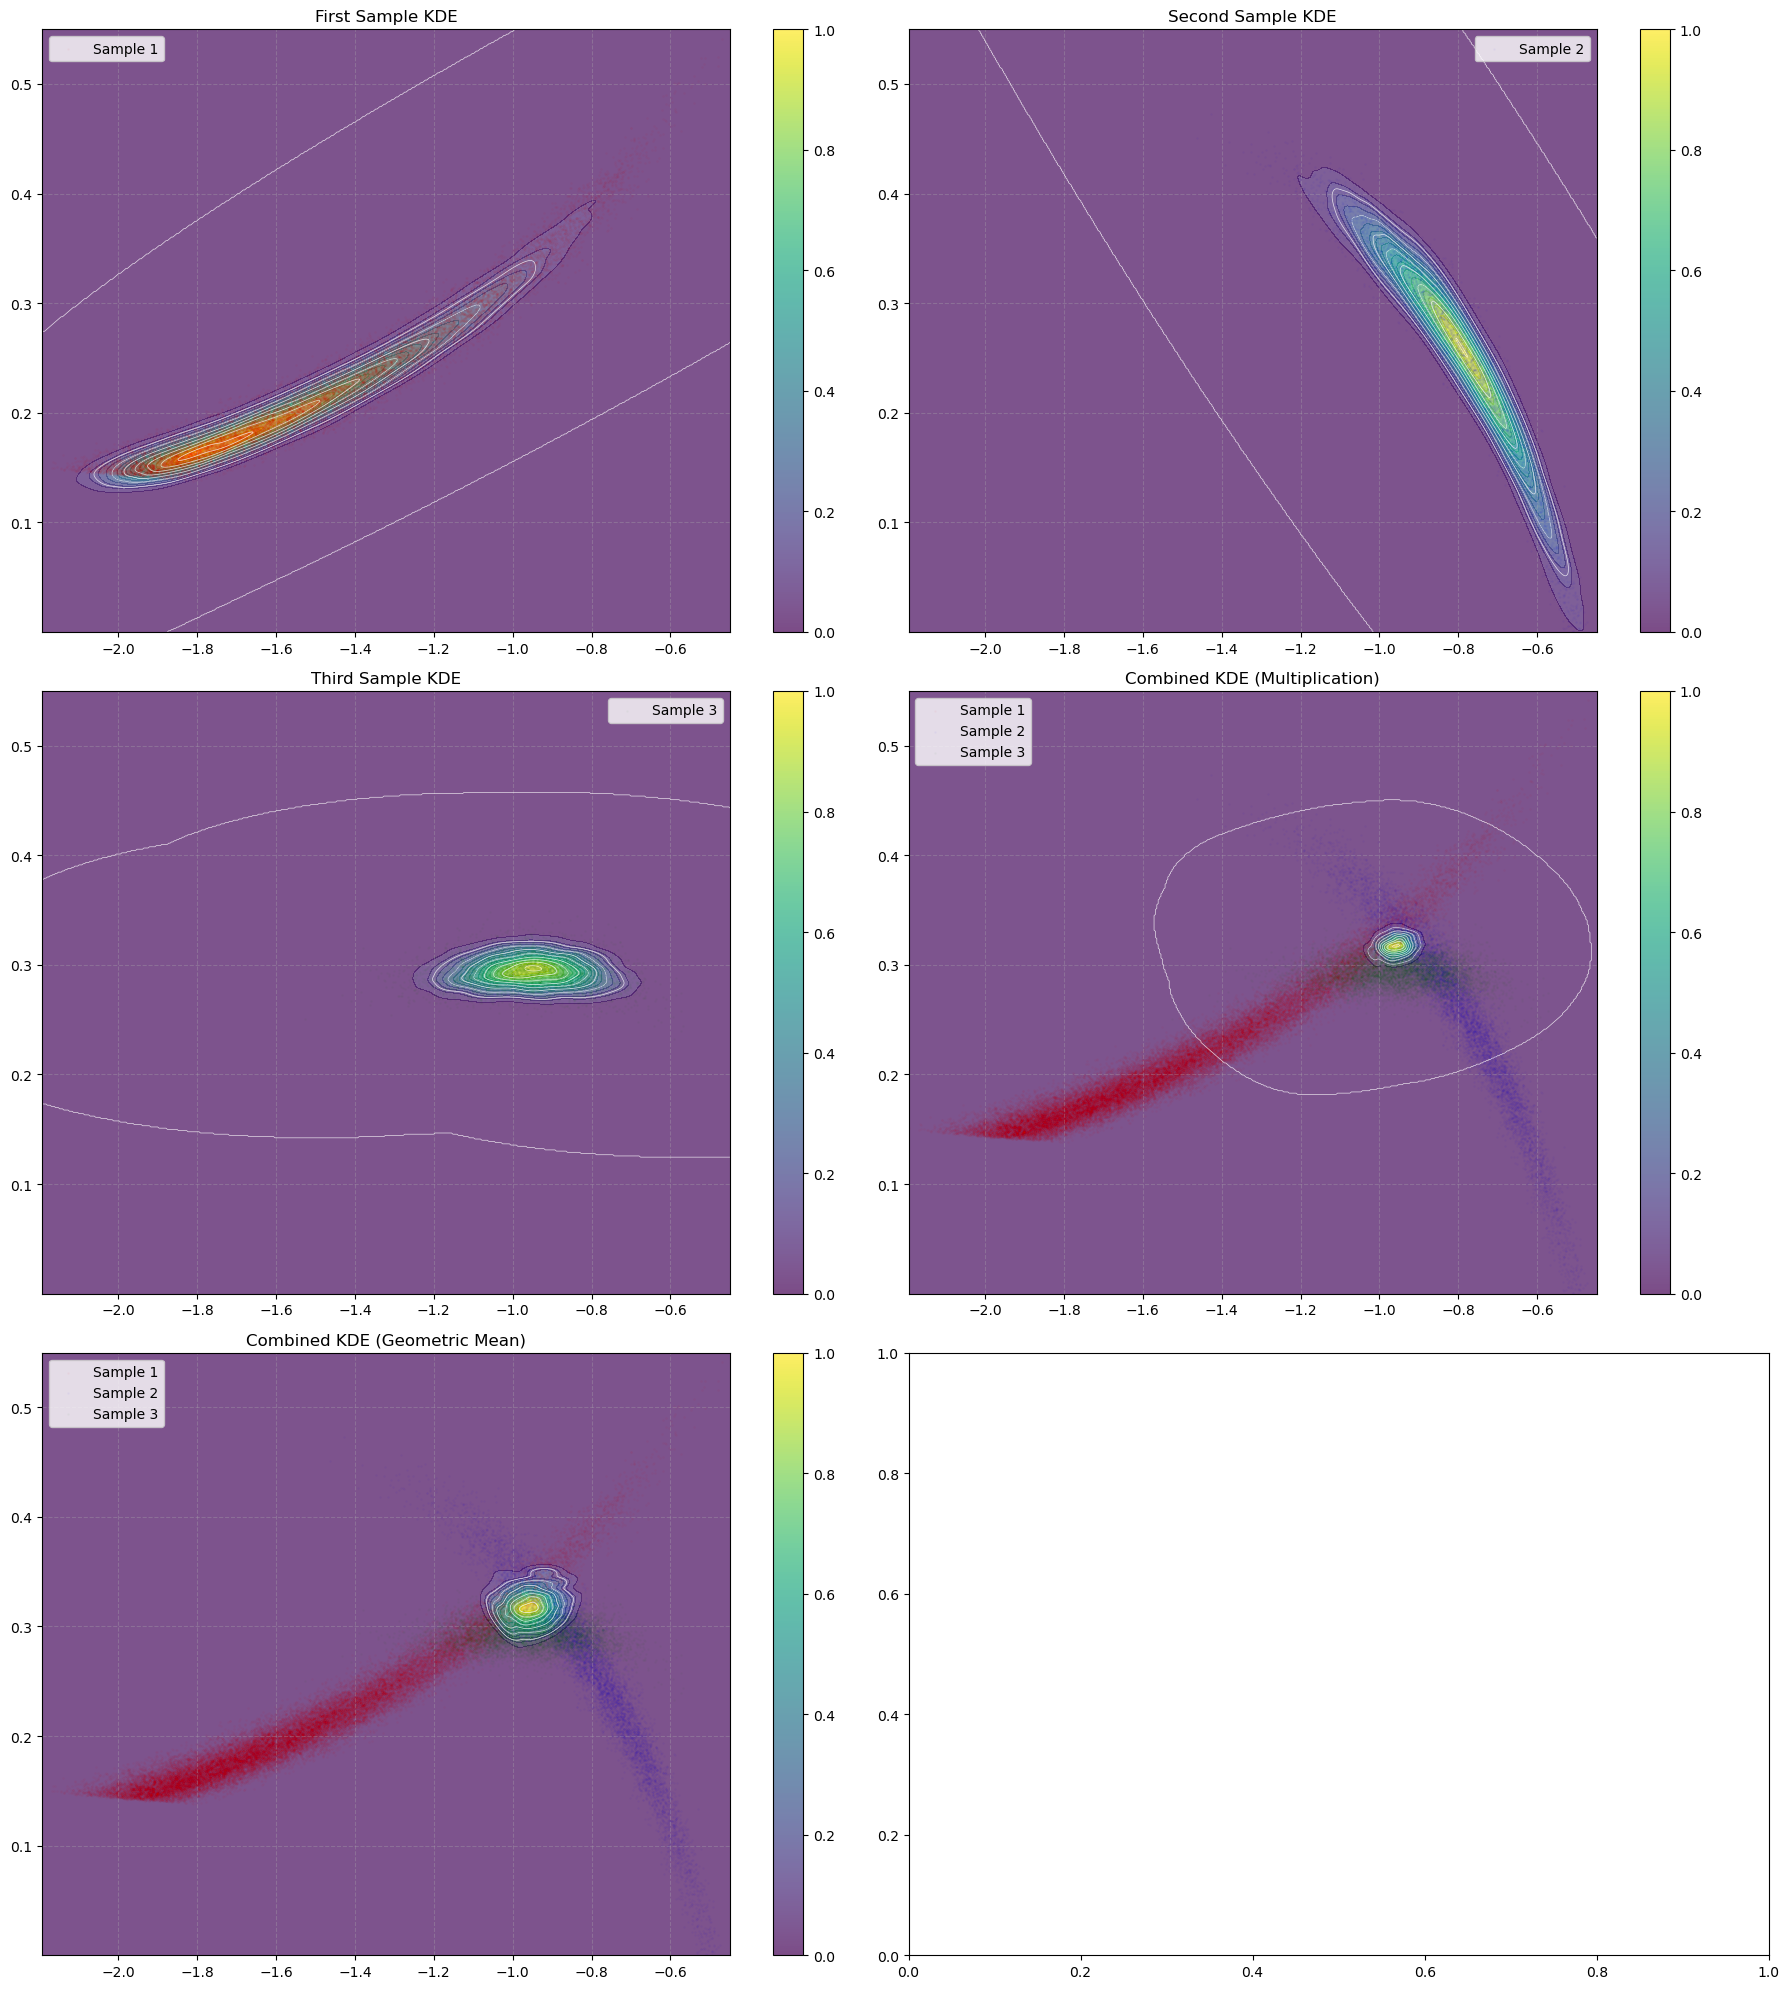

Multiplication Method:
Mode: (-0.9592, 0.3173)
Median: (-0.9592, 0.3162)
Mean: (-0.9583, 0.3174)
Std Dev: (0.0319, 0.0085)
68% CI X: [-0.9907, -0.9277]
68% CI Y: [0.3085, 0.3251]

Geometric Mean Method:
Mode: (-0.9592, 0.3173)
Median: (-0.9592, 0.3173)
Mean: (-0.9584, 0.3166)
Std Dev: (0.0750, 0.0193)
68% CI X: [-1.0152, -0.8997]
68% CI Y: [0.3008, 0.3328]


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [59]:
# Create the improved plots  
#kde4_SN = gaussian_kde(samples_sn_wcdm.T[::-1])
#kde5_BAO= gaussian_kde(samples_bao_wcdm.T[::-1])
fig_other1, stats_mult_combined_other1, stats_geom_combined_other1, combined_samples_CMB_SNe_BAO = plot_kde_comparison_stats_3sample(mcmc_samples_wcdm_Planck_kde, 
                                                                      samples_sn_wcdm[:, ::-1],
                                                                     samples_bao_wcdm[:, ::-1],
                                                                    grid_points=500, 
                                                                    save_file_mult='kde_CMB_SNe_BAO_MULT.h5', 
                                                                    save_file_geom='kde_CMB_SNe_BAO_GEOM1.h5' )
plt.show()

print("Multiplication Method:")
print(f"Mode: ({stats_mult_combined_other1['mode'][0]:.4f}, {stats_mult_combined_other1['mode'][1]:.4f})")
print(f"Median: ({stats_mult_combined_other1['median'][0]:.4f}, {stats_mult_combined_other1['median'][1]:.4f})")
print(f"Mean: ({stats_mult_combined_other1['mean'][0]:.4f}, {stats_mult_combined_other1['mean'][1]:.4f})")
print(f"Std Dev: ({stats_mult_combined_other1['std'][0]:.4f}, {stats_mult_combined_other1['std'][1]:.4f})")
print(f"68% CI X: [{stats_mult_combined_other1['confidence_intervals']['x'][0]:.4f}, {stats_mult_combined_other1['confidence_intervals']['x'][1]:.4f}]")
print(f"68% CI Y: [{stats_mult_combined_other1['confidence_intervals']['y'][0]:.4f}, {stats_mult_combined_other1['confidence_intervals']['y'][1]:.4f}]")

print("\nGeometric Mean Method:")
print(f"Mode: ({stats_geom_combined_other1['mode'][0]:.4f}, {stats_geom_combined_other1['mode'][1]:.4f})")
print(f"Median: ({stats_geom_combined_other1['median'][0]:.4f}, {stats_geom_combined_other1['median'][1]:.4f})")
print(f"Mean: ({stats_geom_combined_other1['mean'][0]:.4f}, {stats_geom_combined_other1['mean'][1]:.4f})")
print(f"Std Dev: ({stats_geom_combined_other1['std'][0]:.4f}, {stats_geom_combined_other1['std'][1]:.4f})")
print(f"68% CI X: [{stats_geom_combined_other1['confidence_intervals']['x'][0]:.4f}, {stats_geom_combined_other1['confidence_intervals']['x'][1]:.4f}]")
print(f"68% CI Y: [{stats_geom_combined_other1['confidence_intervals']['y'][0]:.4f}, {stats_geom_combined_other1['confidence_intervals']['y'][1]:.4f}]")


# Extract stats for convenience
med_x_other1, med_y_other1 = stats_mult_combined_other1['median']
low_x_other1, high_x_other1 = stats_mult_combined_other1['confidence_intervals']['x']
low_y_other1, high_y_other1 = stats_mult_combined_other1['confidence_intervals']['y']

# Calculate uncertainties
minus_x_other1 = med_x_other1 - low_x_other1
plus_x_other1 = high_x_other1 - med_x_other1
minus_y_other1 = med_y_other1 - low_y_other1
plus_y_other1 = high_y_other1 - med_y_other1

# Display nicely formatted LaTeX
display(Latex(rf'Median values (Multiplication): $w = {med_x_other1:.3f}_{{-{minus_x_other1:.3f}}}^{{+{plus_x_other1:.3f}}}$'))
display(Latex(rf'Median values (Multiplication): $\Omega_m = {med_y_other1:.3f}_{{-{minus_y_other1:.3f}}}^{{+{plus_y_other1:.3f}}}$'))


## Combining ALL observations (wCDM)

In [60]:
'''
kde4_SN = gaussian_kde(samples_sn_wcdm.T[::-1])
kde5_BAO= gaussian_kde(samples_bao_wcdm.T[::-1])

x_grid, y_grid = np.mgrid[-2.0:0:100j, 0.0:1:100j ]
positions3 = np.vstack([x_grid.ravel(), y_grid.ravel()])

combined_density_all = kde1_dcls1507(positions3) * kde2_J0946(positions3) * kde3_Planck(positions3) * kde4_SN(positions3) * kde5_BAO(positions3)
combined_density_all = combined_density_all.reshape(x_grid.shape)

# Sort the density values to determine the confidence levels
sorted_density_all = np.sort(combined_density_all.ravel())[::-1]
cumulative_density_all = np.cumsum(sorted_density_all) / np.sum(sorted_density_all)

# Find density thresholds for the desired confidence levels (1, 2 sigma)
levels_all = [
    sorted_density_all[np.searchsorted(cumulative_density_all, 0.9545)],  # 2-sigma
    sorted_density_all[np.searchsorted(cumulative_density_all, 0.6827)],  # 1-sigma
]

# Find the density threshold for the 68% confidence level
threshold_density_all = sorted_density_all[np.searchsorted(cumulative_density_all, 0.6827)] #0.9545
print(threshold_density_all)

# Flatten combined_density and positions
flattened_density_all = combined_density_all.ravel()
flattened_positions_all = positions3.T  # Shape should be (n, 2) where n is the number of grid points

# Create a mask for samples above the threshold
within_bounds_mask_all = flattened_density_all >= threshold_density_all

# Check the mask to see if it is properly constructed
print("Within Bounds Mask Shape:", within_bounds_mask_all.shape)
print("Number of samples within bounds:", np.sum(within_bounds_mask_all))

# Extract filtered samples based on the mask
filtered_samples_all = flattened_positions_all[within_bounds_mask_all]

# Check the shape of the filtered samples
print("Filtered Samples Shape:", filtered_samples_all.shape)

# Separate into w_0 and Ω_m
w_0_samples_all = filtered_samples_all[:, 0]  # First column corresponds to w_0
Omega_m_samples_all = filtered_samples_all[:, 1]  # Second column corresponds to Ω_m

# Calculate the CDF
cdf_all = np.cumsum(combined_density_all.ravel())
cdf_all /= cdf_all[-1]  # Normalize the CDF

median_index_all = np.searchsorted(cdf_all, 0.5)
median_all = positions3[:, median_index_all]  # [w_0, Omega_m]

# Print the median results
print("Median values (w_0, Omega_m):", median_all)
median_all_w0 = np.median(w_0_samples_all)  #median_all[0]
median_all_Omega_m = np.median(Omega_m_samples_all)  #median_all[1]

# Calculate and print the bounds for the filtered samples
all_lower_bound_w0 = np.min(w_0_samples_all)
all_upper_bound_w0 = np.max(w_0_samples_all)

all_lower_bound_Omega_m = np.min(Omega_m_samples_all)
all_upper_bound_Omega_m = np.max(Omega_m_samples_all)

print("68% Confidence Bound for w_0: [{:.4f}, {:.4f}]".format(all_lower_bound_w0, all_upper_bound_w0))
print("68% Confidence Bound for Ω_m: [{:.4f}, {:.4f}]".format(all_lower_bound_Omega_m, all_upper_bound_Omega_m))

# Display the median values with uncertainties
display(Latex(f'Median values: $w = {median_all_w0:.3f}_{{-{median_all_w0 - all_lower_bound_w0:.3f}}}^{{+{all_upper_bound_w0 - median_all_w0:.3f}}}$'))
display(Latex(f'Median values: $\Omega_m = {median_all_Omega_m:.3f}_{{-{median_all_Omega_m - all_lower_bound_Omega_m:.3f}}}^{{+{all_upper_bound_Omega_m - median_all_Omega_m:.3f}}}$'))
'''

'\nkde4_SN = gaussian_kde(samples_sn_wcdm.T[::-1])\nkde5_BAO= gaussian_kde(samples_bao_wcdm.T[::-1])\n\nx_grid, y_grid = np.mgrid[-2.0:0:100j, 0.0:1:100j ]\npositions3 = np.vstack([x_grid.ravel(), y_grid.ravel()])\n\ncombined_density_all = kde1_dcls1507(positions3) * kde2_J0946(positions3) * kde3_Planck(positions3) * kde4_SN(positions3) * kde5_BAO(positions3)\ncombined_density_all = combined_density_all.reshape(x_grid.shape)\n\n# Sort the density values to determine the confidence levels\nsorted_density_all = np.sort(combined_density_all.ravel())[::-1]\ncumulative_density_all = np.cumsum(sorted_density_all) / np.sum(sorted_density_all)\n\n# Find density thresholds for the desired confidence levels (1, 2 sigma)\nlevels_all = [\n    sorted_density_all[np.searchsorted(cumulative_density_all, 0.9545)],  # 2-sigma\n    sorted_density_all[np.searchsorted(cumulative_density_all, 0.6827)],  # 1-sigma\n]\n\n# Find the density threshold for the 68% confidence level\nthreshold_density_all = sorte

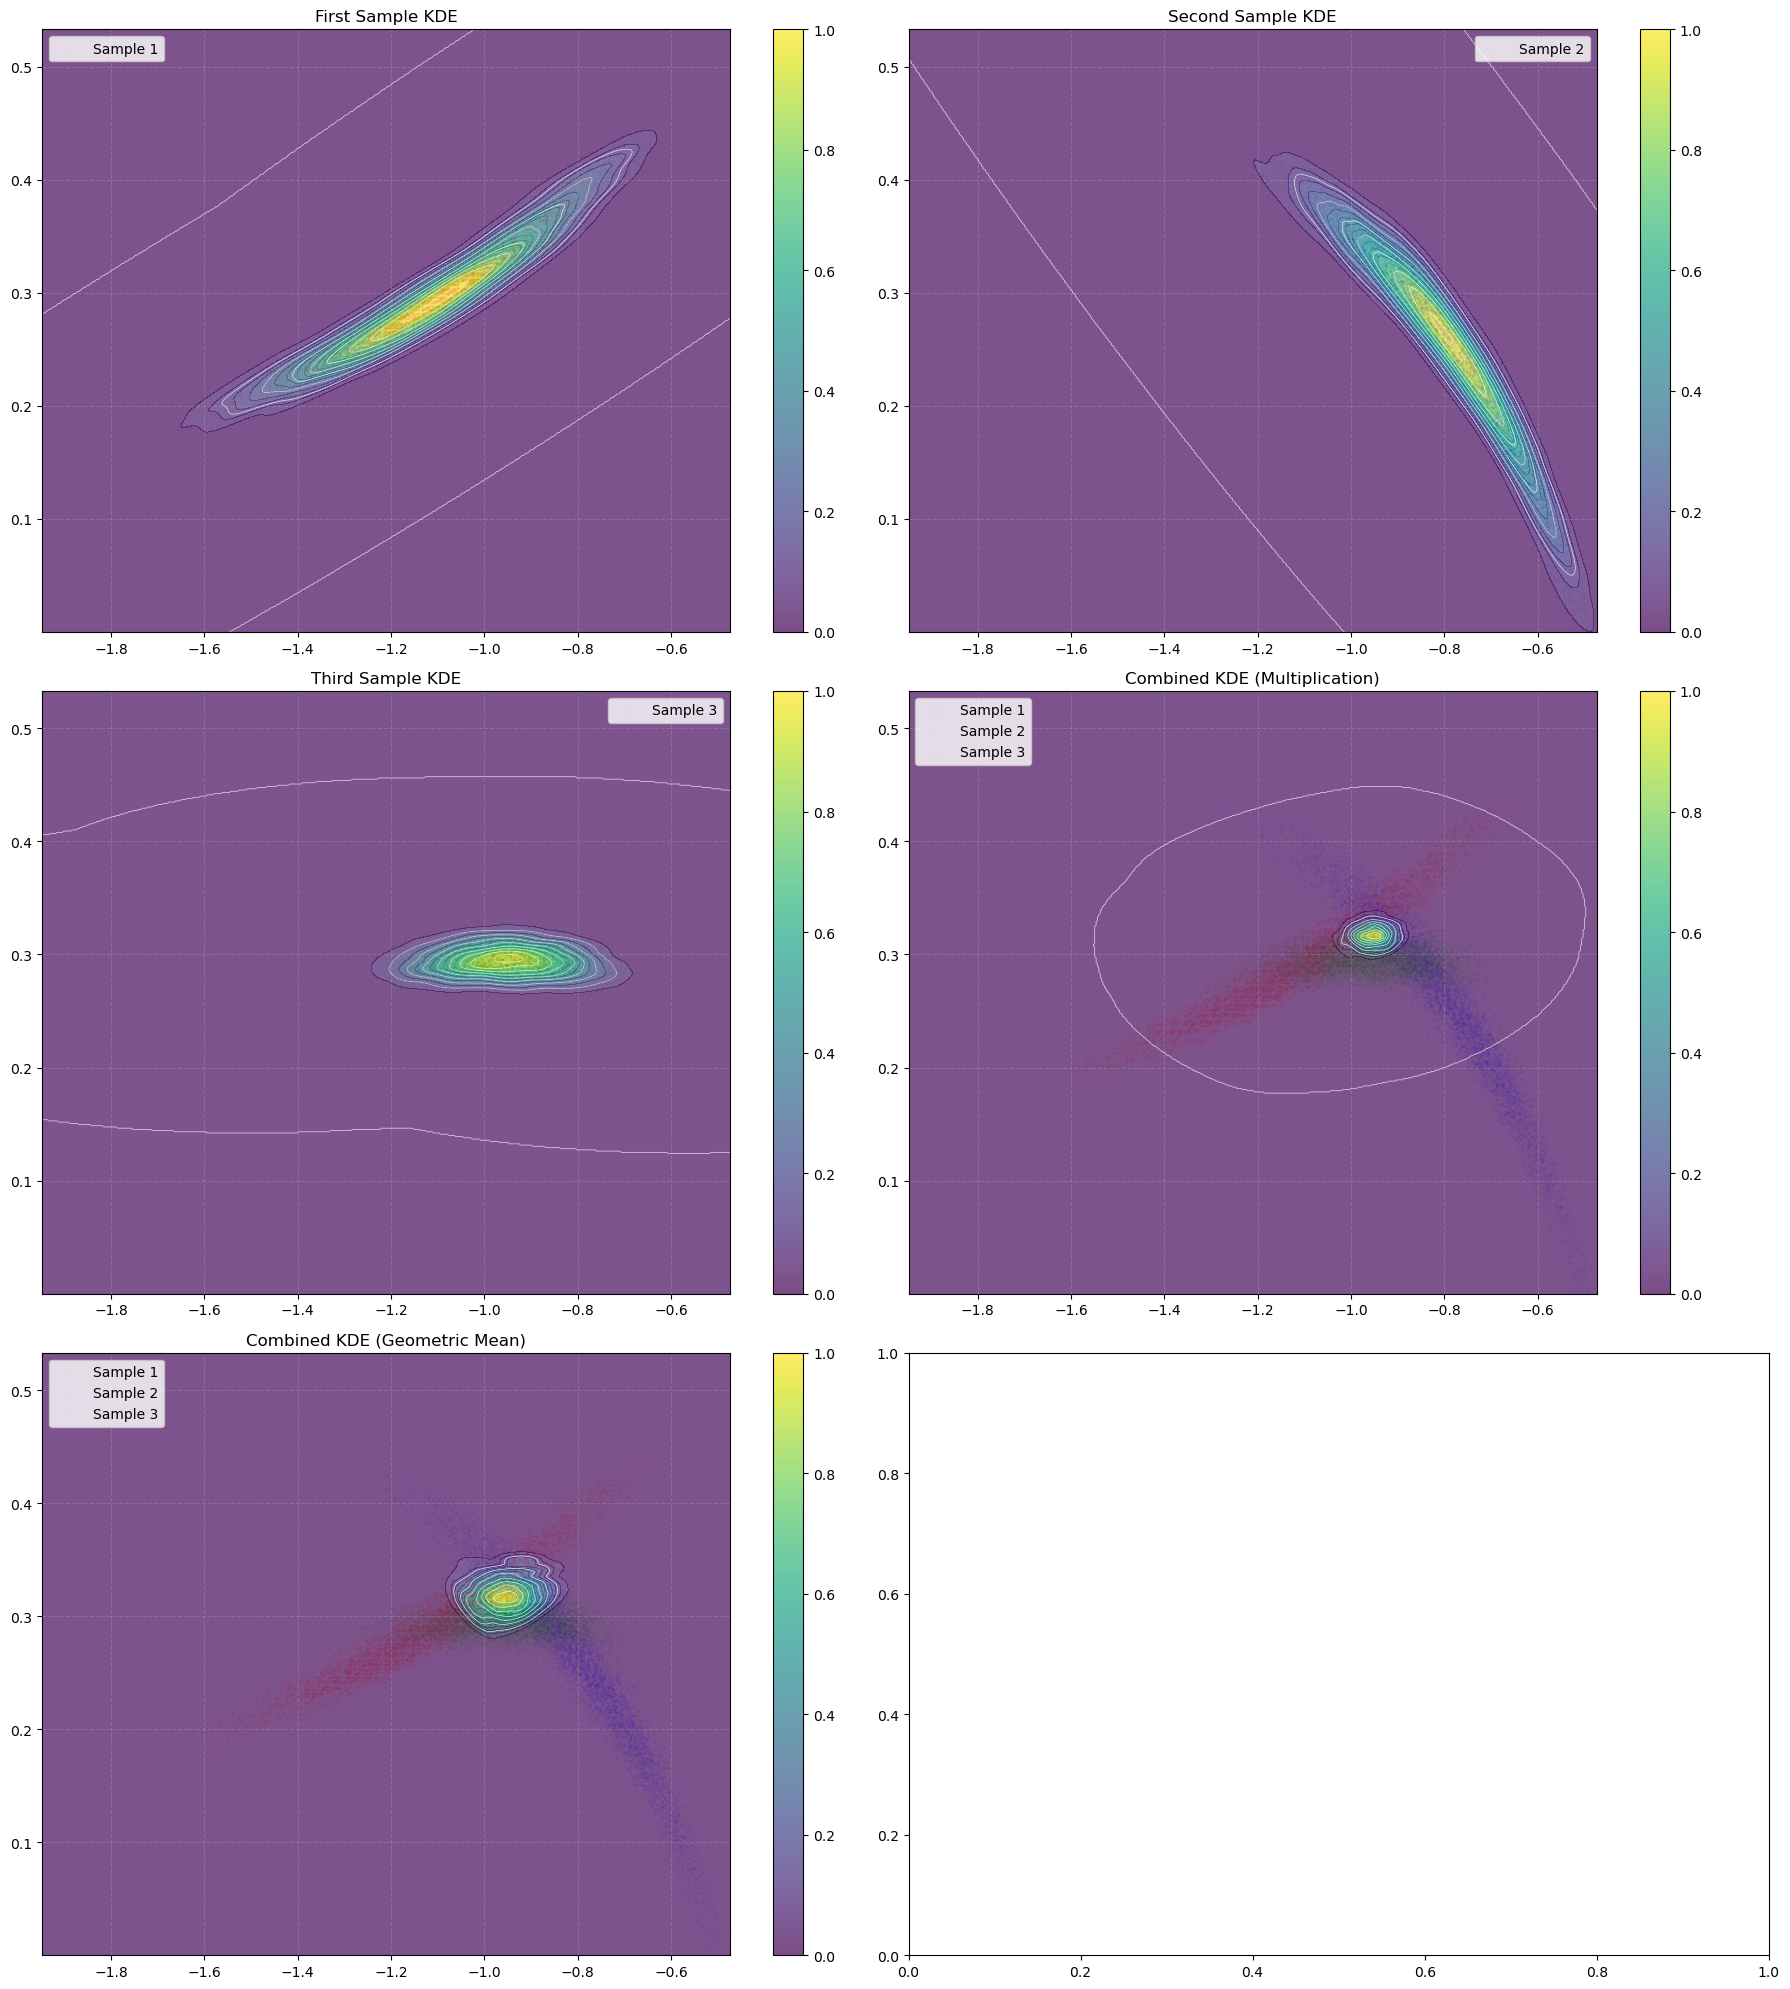

Multiplication Method:
Mode: (-0.9461, 0.3173)
Median: (-0.9549, 0.3162)
Mean: (-0.9545, 0.3170)
Std Dev: (0.0325, 0.0087)
68% CI X: [-0.9875, -0.9224]
68% CI Y: [0.3077, 0.3248]

Geometric Mean Method:
Mode: (-0.9461, 0.3173)
Median: (-0.9549, 0.3173)
Mean: (-0.9569, 0.3174)
Std Dev: (0.0657, 0.0176)
68% CI X: [-1.0141, -0.9017]
68% CI Y: [0.3013, 0.3333]


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [61]:
# Create the improved plots  
#kde4_SN = gaussian_kde(samples_sn_wcdm.T[::-1])
#kde5_BAO= gaussian_kde(samples_bao_wcdm.T[::-1])
#combined_DSPL_CMB_samples filtered_samples_DSPLs_Planck_95
fig_all1, stats_mult_combined_all1, stats_geom_combined_all1, combined_samples_all1 = plot_kde_comparison_stats_3sample(
                                                                       combined_DSPL_CMB_samples, 
                                                                      samples_sn_wcdm[:, ::-1],
                                                                     samples_bao_wcdm[:, ::-1], 
                                                                    grid_points=500, 
                                                                    save_file_mult='kde_all1_MULT.h5', 
                                                                    save_file_geom='kde_all1_GEOM1.h5')
plt.show()

print("Multiplication Method:")
print(f"Mode: ({stats_mult_combined_all1['mode'][0]:.4f}, {stats_mult_combined_all1['mode'][1]:.4f})")
print(f"Median: ({stats_mult_combined_all1['median'][0]:.4f}, {stats_mult_combined_all1['median'][1]:.4f})")
print(f"Mean: ({stats_mult_combined_all1['mean'][0]:.4f}, {stats_mult_combined_all1['mean'][1]:.4f})")
print(f"Std Dev: ({stats_mult_combined_all1['std'][0]:.4f}, {stats_mult_combined_all1['std'][1]:.4f})")
print(f"68% CI X: [{stats_mult_combined_all1['confidence_intervals']['x'][0]:.4f}, {stats_mult_combined_all1['confidence_intervals']['x'][1]:.4f}]")
print(f"68% CI Y: [{stats_mult_combined_all1['confidence_intervals']['y'][0]:.4f}, {stats_mult_combined_all1['confidence_intervals']['y'][1]:.4f}]")

print("\nGeometric Mean Method:")
print(f"Mode: ({stats_geom_combined_all1['mode'][0]:.4f}, {stats_geom_combined_all1['mode'][1]:.4f})")
print(f"Median: ({stats_geom_combined_all1['median'][0]:.4f}, {stats_geom_combined_all1['median'][1]:.4f})")
print(f"Mean: ({stats_geom_combined_all1['mean'][0]:.4f}, {stats_geom_combined_all1['mean'][1]:.4f})")
print(f"Std Dev: ({stats_geom_combined_all1['std'][0]:.4f}, {stats_geom_combined_all1['std'][1]:.4f})")
print(f"68% CI X: [{stats_geom_combined_all1['confidence_intervals']['x'][0]:.4f}, {stats_geom_combined_all1['confidence_intervals']['x'][1]:.4f}]")
print(f"68% CI Y: [{stats_geom_combined_all1['confidence_intervals']['y'][0]:.4f}, {stats_geom_combined_all1['confidence_intervals']['y'][1]:.4f}]")

# Extract stats for convenience
med_x, med_y = stats_mult_combined_all1['median']
low_x, high_x = stats_mult_combined_all1['confidence_intervals']['x']
low_y, high_y = stats_mult_combined_all1['confidence_intervals']['y']

# Calculate uncertainties
minus_x = med_x - low_x
plus_x = high_x - med_x
minus_y = med_y - low_y
plus_y = high_y - med_y

# Display nicely formatted LaTeX
display(Latex(rf'Median values (Multiplication): $w = {med_x:.3f}_{{-{minus_x:.3f}}}^{{+{plus_x:.3f}}}$'))
display(Latex(rf'Median values (Multiplication): $\Omega_m = {med_y:.3f}_{{-{minus_y:.3f}}}^{{+{plus_y:.3f}}}$'))


### Plotting all studies

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


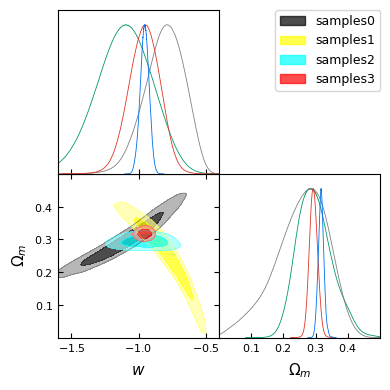

In [64]:
# Parameter names and LaTeX-formatted labels
param_names = ['w', 'omega_m']
param_labels = [r"w", r"\Omega_m"]  # LaTeX formatting for labels

# Creating MCSamples for each dataset with mathematical labels
gdsamples_dcls_CMB = MCSamples(samples=combined_DSPL_CMB_samples, names=param_names, labels=param_labels)
gdsamples_sn = MCSamples(samples=samples_sn_wcdm.T[::-1].T, names=param_names, labels=param_labels)
gdsamples_bao = MCSamples(samples=samples_bao_wcdm.T[::-1].T, names=param_names, labels=param_labels)

# Reduce bin size for the fourth dataset
gdsamples_all = MCSamples(samples=combined_samples_all1, names=param_names, labels=param_labels)
gdsamples_all.updateSettings({'fine_bins_2D': 10})  # Reduce bin size

# Set up plotter
g = plots.get_subplot_plotter()
fig = plt.figure(figsize=(10, 10))  # Adjusted figure size

# Define axis limits
range_limits = {'w': [-1.6, -0.4], 'omega_m': [0., 0.5]}

# Generate triangle plot with LaTeX labels
g.triangle_plot(
    [gdsamples_dcls_CMB, gdsamples_sn, gdsamples_bao, gdsamples_all], 
    filled=True, 
    contour_args={'alpha': 0.7},
    param_limits=range_limits, 
    get_density=False,  # Disables KDE
    colors=['black', 'yellow', 'cyan', 'red']
)


#plt.savefig(
#    f'/Users/nandinisahu/Library/CloudStorage/OneDrive-UNSW/AGEL/Paper_DSPL/{job_name_out}_wCDM_final_combined1.pdf', #_combined_99
#    dpi=1200 )


plt.close(fig)


Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


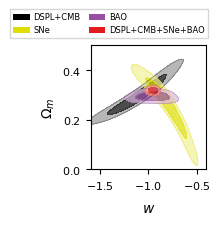

In [65]:
#combined_DSPL_CMB_samples, filtered_samples_DSPLs_Planck_95

DSPLs_Planck_wcdm = MCSamples(samples=combined_DSPL_CMB_samples, names=param_names, labels=param_labels)
DSPLs_Planck_wcdm.updateSettings({'fine_bins_2D': 80, 'smooth_scale_2D': 0.5})  # Higher bin count & smoothing

SNe_wcdm = MCSamples(samples=samples_sn_wcdm.T[::-1].T, names=param_names, labels=param_labels)
SNe_wcdm.updateSettings({'fine_bins_2D': 80, 'smooth_scale_2D': 0.5})  # Higher bin count & smoothing

BAO_wcdm = MCSamples(samples=samples_bao_wcdm.T[::-1].T, names=param_names, labels=param_labels)
BAO_wcdm.updateSettings({'fine_bins_2D': 80, 'smooth_scale_2D': 0.5})  # Higher bin count & smoothing

#combined_samples_all1  filtered_samples_all1_99
combined_wcdm = MCSamples(samples=combined_samples_all1, names=param_names, labels=param_labels)
combined_wcdm.updateSettings({'fine_bins_2D': 80, 'smooth_scale_2D': 0.5})  # Higher bin count & smoothing



#df_DSPLs_wcdm = pd.DataFrame(filtered_samples_DSPLs, columns=[r"$w$", r"$\Omega_m$"])


g = plots.get_subplot_plotter()
fig = plt.figure(figsize=(15, 15))

g.plot_2d([DSPLs_Planck_wcdm, SNe_wcdm, BAO_wcdm,combined_wcdm], param1='w', param2='omega_m', 
          filled=[True,True,True,True], 
          fine_bins=80,  # Higher bin count
          colors=['black',CB_color_cycle['yellow'],CB_color_cycle['purple'],CB_color_cycle['red']], 
          alphas=[0.7, 0.7, 0.7,0.7], 
          #smooth_scale_2D=0.5,  # Apply KDE smoothing
          linewidths=[1,1,1,2],
          #contour_args={'linewidths': 4} 
         )

range_limits = {'w': [-1.6, -0.4], 'omega_m': [0.0, 0.5]}  # Adjust ranges as needed
g.set_axes(param_limits=range_limits)

ax = plt.gca()  # Get the current axes

# Manually set the axes limits if needed
plt.xlim(range_limits['w'])
plt.ylim(range_limits['omega_m'])


#contours = plt.contour(x_grid, y_grid, combined_density_DSPLs, levels=cof_levels, colors=[ '#4daf4a', '#4daf4a'], linewidths=[1, 2]) #'yellow',


# Set axes labels
ax.set_xlabel(r"$w$", fontsize=10)  # X-axis label
ax.set_ylabel(r"$\Omega_m$", fontsize=10)  # Y-axis label

# Add custom legend
legend_elements = [
    Patch(facecolor='black', label='DSPL+CMB'),
    Patch(facecolor=CB_color_cycle['yellow'], label='SNe'),
    Patch(facecolor=CB_color_cycle['purple'], label='BAO'),
    Patch(facecolor=CB_color_cycle['red'], label='DSPL+CMB+SNe+BAO'),
    #Line2D([0], [0], color=CB_color_cycle['red'], lw=2, label='DSPLxCMBxSNexBAO'),
]

# Add the legend to the plot
ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1.32), fancybox=False, shadow=False,
          ncol=2, fontsize=6, handletextpad=0.4, columnspacing=1)

plt.savefig(f'/Users/nandinisahu/Library/CloudStorage/OneDrive-UNSW/AGEL/Paper_DSPL/{job_name_out}_wCDM_all_new_method.pdf', dpi=1200, bbox_inches='tight')

plt.close(fig)
